In [1]:
from IPython import get_ipython
from IPython.display import display

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re

In [3]:
custom_colors = ['#D496A7','#edafb8', '#f7e1d7', '#dedbd2', '#b0c4b1', '#8AA399','#4a5759']

%config InlineBackend.figure_format='retina'
sns.set_theme(context='paper', style='whitegrid', palette=custom_colors, font='sans-serif', font_scale=1, color_codes=True,
              rc={'grid.alpha': 0.5, 'axes.titlesize': 14, 'figure.figsize': (10, 5)})

In [4]:
sns.color_palette(custom_colors)

[(0.8313725490196079, 0.5882352941176471, 0.6549019607843137),
 (0.9294117647058824, 0.6862745098039216, 0.7215686274509804),
 (0.9686274509803922, 0.8823529411764706, 0.8431372549019608),
 (0.8705882352941177, 0.8588235294117647, 0.8235294117647058),
 (0.6901960784313725, 0.7686274509803922, 0.6941176470588235),
 (0.5411764705882353, 0.6392156862745098, 0.6),
 (0.2901960784313726, 0.3411764705882353, 0.34901960784313724)]

In [5]:
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

In [6]:
salaries = pd.read_csv('/content/drive/MyDrive/PROJECT/DataScience_salaries_2025.csv')

In [7]:
salaries.drop_duplicates(inplace=True)
salaries.columns = salaries.columns.str.strip().str.lower()

salaries['salary_currency'] = salaries['salary_currency'].str.upper()

In [8]:
salaries.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [9]:
print('Basic Information about the Dataset:\n')
print('- There are {} observations and {} features in this dataset. \n'.format(salaries.shape[0],salaries.shape[1]))

print('- There are {} unique Job Titles in this dataset such as {}... \n'.format(len(salaries.job_title.unique()),
                                                                           ', '.join(salaries.job_title.unique()[0:3])))

print('- There are {} experience levels in this dataset such as {}.\n'.format(len(salaries.experience_level.unique()),
                                                                              ', '.join(salaries.experience_level.unique()[::])))
print('- There are {} employment types in this dataset such as {}.\n'.format(len(salaries.employment_type.unique()),
                                                                              ', '.join(salaries.employment_type.unique()[::])))

print('- There are {} company locations, and {} employee residence countries. \n'.format(len(salaries.company_location.unique()),
                                                                                       len(salaries.employee_residence.unique())))
print('- There are {} company sizes such as {}. \n'.format(len(salaries.company_size.unique()),
                                                          ', '.join(salaries.company_size.unique())))
print('- Annual salary in USD varies form {} to {}'.format(salaries.salary_in_usd.min(), salaries.salary_in_usd.max()))

Basic Information about the Dataset:

- There are 46637 observations and 11 features in this dataset. 

- There are 317 unique Job Titles in this dataset such as Research Scientist, AI Engineer, Manager... 

- There are 4 experience levels in this dataset such as MI, SE, EN, EX.

- There are 4 employment types in this dataset such as FT, PT, CT, FL.

- There are 90 company locations, and 96 employee residence countries. 

- There are 3 company sizes such as M, L, S. 

- Annual salary in USD varies form 15000 to 800000


In [10]:
salaries['work_year'].unique()

array([2025, 2024, 2022, 2023, 2020, 2021])

In [11]:
salaries.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


Text(0.5, 1.0, 'Missing Values')

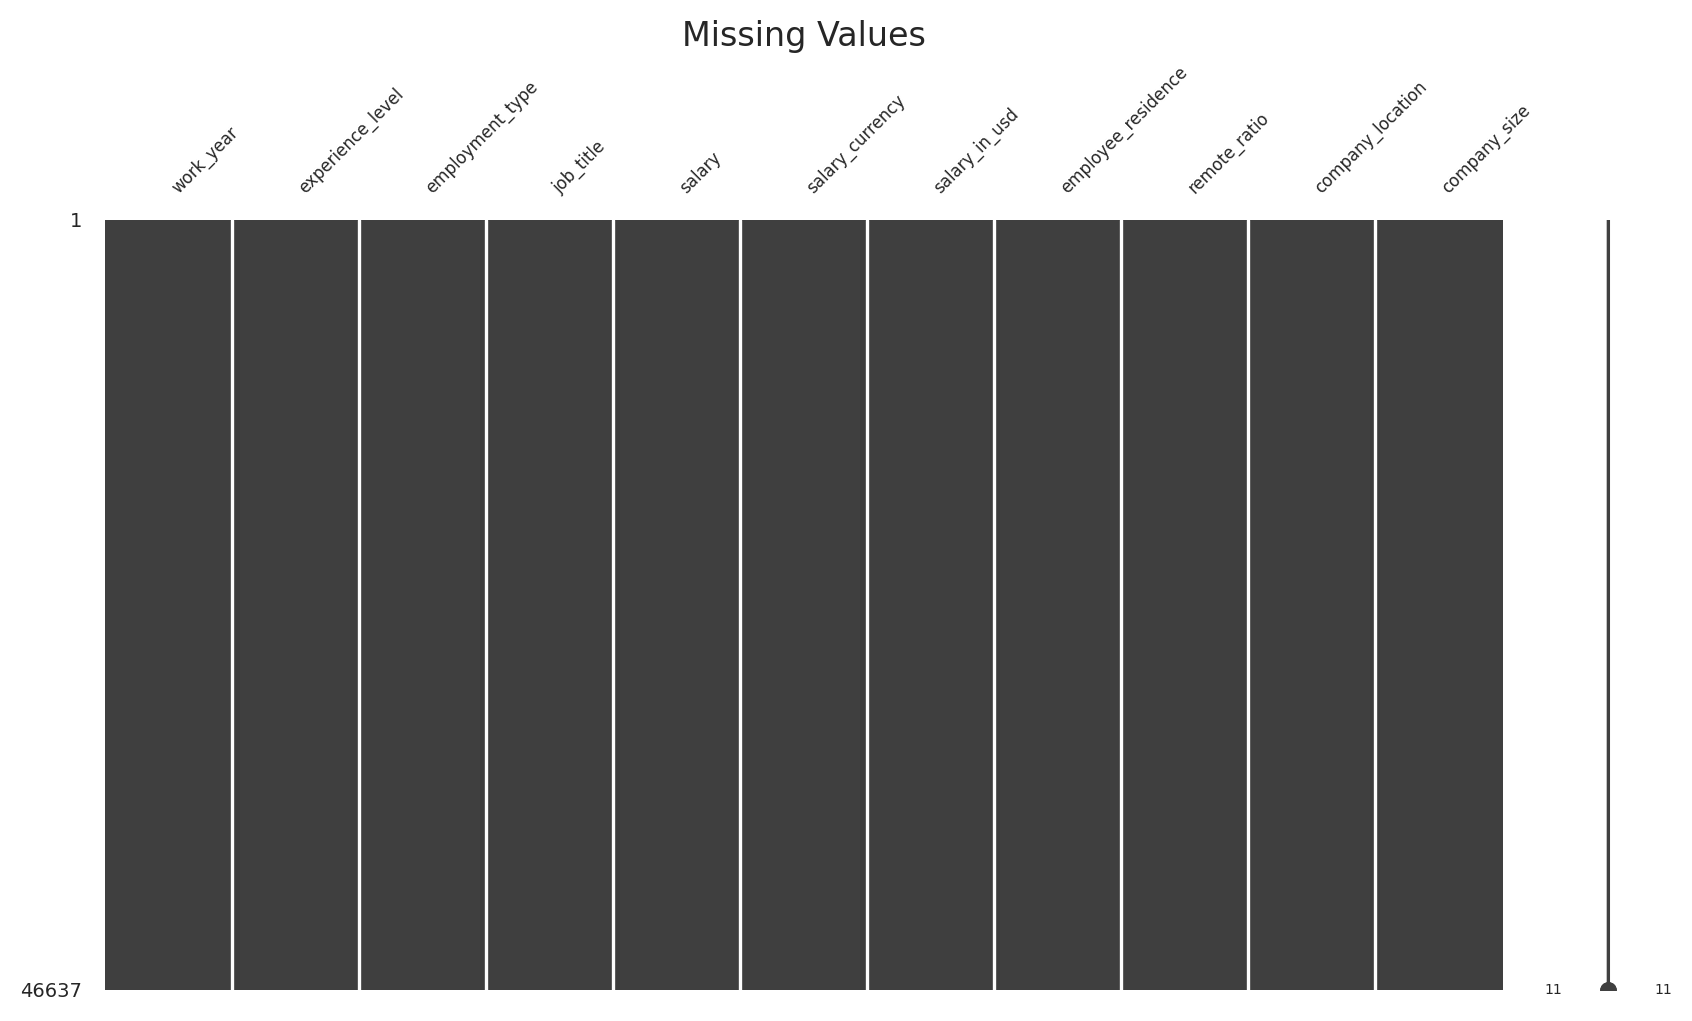

In [12]:
import missingno as msno
msno.matrix(salaries, figsize=(10, 5), fontsize=6)
plt.title('Missing Values',fontsize=12)

In [13]:
#FEATURE ENGINEERING

In [14]:
salaries['job_title'].value_counts().head(15)

,count
job_title,
Data Scientist,5392
Data Engineer,5134
Data Analyst,4570
Software Engineer,3172
Engineer,2712
Machine Learning Engineer,2688
Manager,2171
Analyst,1439
Research Scientist,1074


In [15]:
salaries[salaries['job_title'].str.match('^Data Scien', case=True)]['job_title'].unique()

array(['Data Scientist', 'Data Scientist Associate',
       'Data Scientist Manager', 'Data Scientist Lead',
       'Data Science Tech Lead'], dtype=object)

In [16]:
# Replace 'Data Science' with 'Data Scientist' in the job_title column
salaries['job_title'] = salaries['job_title'].replace('Data Science', 'Data Scientist')

# Check the result
print('Number of "Data Science" job titles: {}'.format(int(salaries[salaries['job_title'] == 'Data Science'].value_counts().sum())))

Number of "Data Science" job titles: 0


In [17]:
# Function for categorizing job titles
def categorize_job_titles(df, job_title_column='job_title'):
    # Dictionary of job categories and their associated regex patterns
    categories = {
        'Managerial': [r'\b(head|lead|data lead|chief|principal|director|manager|vp|product own|data strateg)\w*'],
        'Research': [r'research'],
        'Data Science': [r'\b(data scien|ai scien|ai eng|applied scien|research scien|decision scien|prompt eng|ai soft)\w*'],
        'Data Analytics': [r'\b(data analy|data quality anal|bi|business intelligen|data strateg|data visual|analytics|data spec|reporting anal|insight anal)\w*'],
        'Data Engineering': [r'\b(data engineer|data quality eng|etl|data architect|data dev|data model|data infra|data pipeline|data integ|database engineer|data manag|data oper)\w*'],
        'Machine Learning': [r'(machine learn|ml|ai|deep learn|nlp|big data|computer vis|cv engineer|vision|mlops|robotic|autonomous veh)\w*']
    }

    def categorize(title):
        # Convert the title to lowercase for case-insensitive matching
        title = title.lower()

        # Initialize an empty list to store matched categories
        matched_categories = []

        # Iterate through each category and its patterns
        for category, patterns in categories.items():
            # Check if any pattern in the category matches the title
            if any(re.search(pattern, title) for pattern in patterns):
                # If a match is found, add the category to the matched list
                matched_categories.append(category)

        # Prioritize categories and special case for 'Data Manager'
        if 'data manager' in title:
            return 'Data Engineering'
        elif 'Managerial' in matched_categories:
            return 'Managerial'
        elif matched_categories:
            return matched_categories[0]
        else:
            return 'Other'

    # Apply the categorize function to each job title in the dataframe
    df['job_category'] = df[job_title_column].apply(categorize)

    # Return the updated dataframe
    return df

In [18]:
# Apply function to the salaries dataframe
salaries = categorize_job_titles(salaries)

In [19]:
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
0,2025,MI,FT,Research Scientist,208000,USD,208000,US,0,US,M,Research
1,2025,MI,FT,Research Scientist,147000,USD,147000,US,0,US,M,Research
2,2025,SE,FT,Research Scientist,173000,USD,173000,US,0,US,M,Research
3,2025,SE,FT,Research Scientist,117000,USD,117000,US,0,US,M,Research
4,2025,MI,FT,AI Engineer,100000,USD,100000,US,100,US,M,Data Science


In [20]:
salaries[['job_title', 'job_category']].drop_duplicates().reset_index(drop=True).sort_values(by='job_title')

,job_title,job_category
8,AI Architect,Machine Learning
148,AI Data Engineer,Data Engineering
128,AI Data Scientist,Data Science
77,AI Developer,Machine Learning
1,AI Engineer,Data Science
...,...,...
166,Tech Lead,Managerial
94,Technical Lead,Managerial
189,Technical Specialist,Other
194,Technical Writer,Other


In [21]:
salaries['experience_level'].unique()

array(['MI', 'SE', 'EN', 'EX'], dtype=object)

In [22]:
# Renaming experience_level field
salaries['experience_level'] = salaries['experience_level'].replace({
    'EN': 'Junior',
    'MI': 'Middle',
    'SE': 'Senior',
    'EX': 'Executive'
})
salaries['experience_level'].unique()

array(['Middle', 'Senior', 'Junior', 'Executive'], dtype=object)

In [23]:
# Checking for unique values
salaries['employment_type'].unique()

array(['FT', 'PT', 'CT', 'FL'], dtype=object)

In [24]:
# Renaming employment_type field
salaries['employment_type'] = salaries['employment_type'].replace({
    'FT': 'Full Time',
    'PT': 'Part Time',
    'CT': 'Consultant',
    'FL': 'Freelance'
})
salaries['employment_type'].unique()

array(['Full Time', 'Part Time', 'Consultant', 'Freelance'], dtype=object)

In [25]:
# Checking for unique values
salaries['remote_ratio'].unique()

array([  0, 100,  50])

In [26]:
# Renaming remote_ratio  field
salaries['remote_ratio'] = salaries['remote_ratio'].replace({
    100: 'Fully Remote',
    50: 'Partially Remote',
    0: 'On-site Work'
})

salaries['remote_ratio'].unique()

array(['On-site Work', 'Fully Remote', 'Partially Remote'], dtype=object)

In [27]:
#creating a new column salary_level
# Get the 25th, 50th (median), and 75th percentiles in one call
twenty_fifth, salaries_median, seventy_fifth = salaries['salary_in_usd'].quantile([0.25, 0.50, 0.75])

# Create salary labels
salary_labels = ['entry', 'mid', 'adv', 'exec']

# Create the salary ranges list
salary_ranges = [0, twenty_fifth, salaries_median, seventy_fifth, salaries['salary_in_usd'].max()]

# Create salary_level
salaries['salary_level'] = pd.cut(salaries['salary_in_usd'],bins=salary_ranges,labels=salary_labels)

In [28]:
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,salary_level
0,2025,Middle,Full Time,Research Scientist,208000,USD,208000,US,On-site Work,US,M,Research,exec
1,2025,Middle,Full Time,Research Scientist,147000,USD,147000,US,On-site Work,US,M,Research,adv
2,2025,Senior,Full Time,Research Scientist,173000,USD,173000,US,On-site Work,US,M,Research,adv
3,2025,Senior,Full Time,Research Scientist,117000,USD,117000,US,On-site Work,US,M,Research,mid
4,2025,Middle,Full Time,AI Engineer,100000,USD,100000,US,Fully Remote,US,M,Data Science,mid


In [29]:
import pandas as pd

data_science_jobs = salaries[salaries['job_title'].str.contains('Data Science|Data Scientist', case=False, na=False)]
data_science_jobs = data_science_jobs[(data_science_jobs['work_year'] >= 2020) & (data_science_jobs['work_year'] <= 2025)]

salary_stats = data_science_jobs.groupby('work_year')['salary_in_usd'].agg(['mean', 'std']).reset_index()

salary_stats.rename(columns={'mean': 'average_salary', 'std': 'salary_std_dev'}, inplace=True)

print(salary_stats)


   work_year  average_salary  salary_std_dev
0       2020   115201.448276    93271.997132
1       2021   103773.671642    67245.552340
2       2022   136145.332237    61902.791481
3       2023   160267.469968    67016.296381
4       2024   155117.134343    74152.035610
5       2025   147966.491556    71884.904570


In [30]:
#  Work Year overall distribution

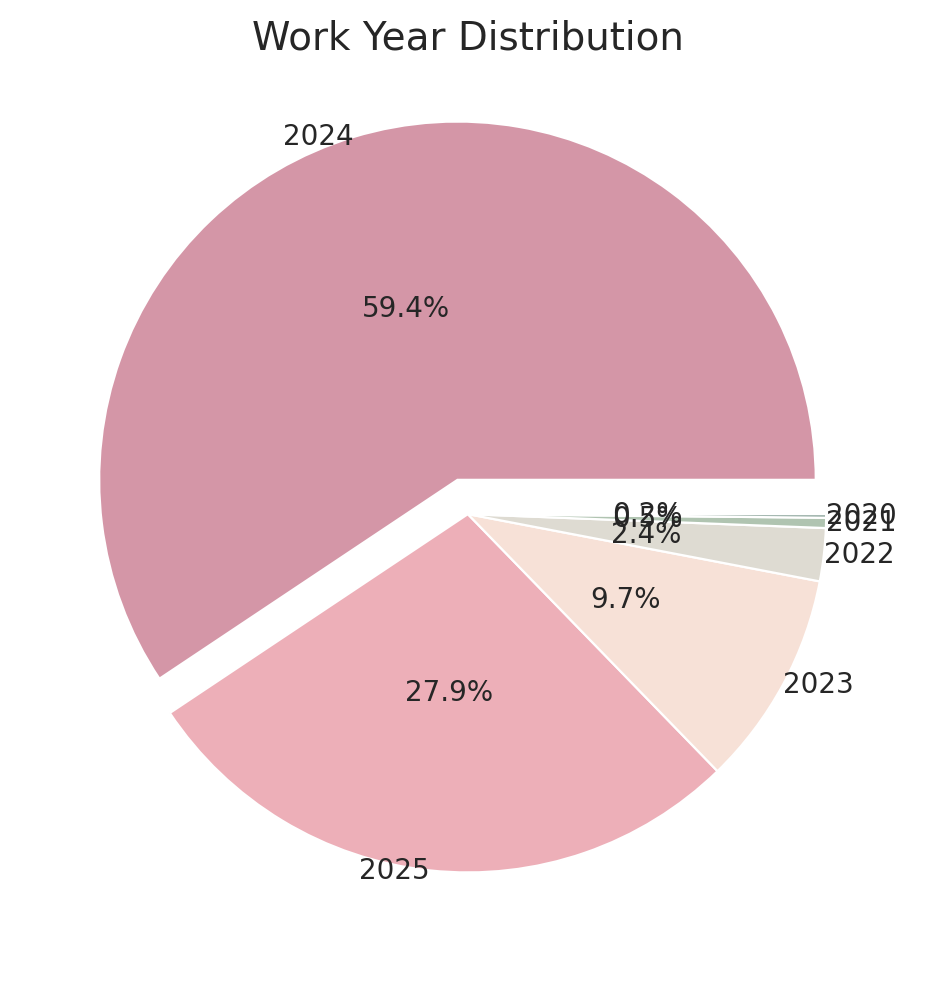

In [31]:
work_year_counts = salaries['work_year'].value_counts(normalize=True)
fig, ax = plt.subplots()

explode = [0.1 if i == work_year_counts.idxmax() else 0 for i in work_year_counts.index]

wedges, texts, autotexts = ax.pie(work_year_counts.values,
                                  labels=work_year_counts.index,
                                  autopct='%1.1f%%',
                                  pctdistance=0.5,
                                  labeldistance=1,
                                  explode=explode)

plt.title('Work Year Distribution')
plt.setp(autotexts, size=10)
plt.setp(texts, size=10)
plt.tight_layout()
plt.show()

In [32]:
# Experience Level Overall Distribution

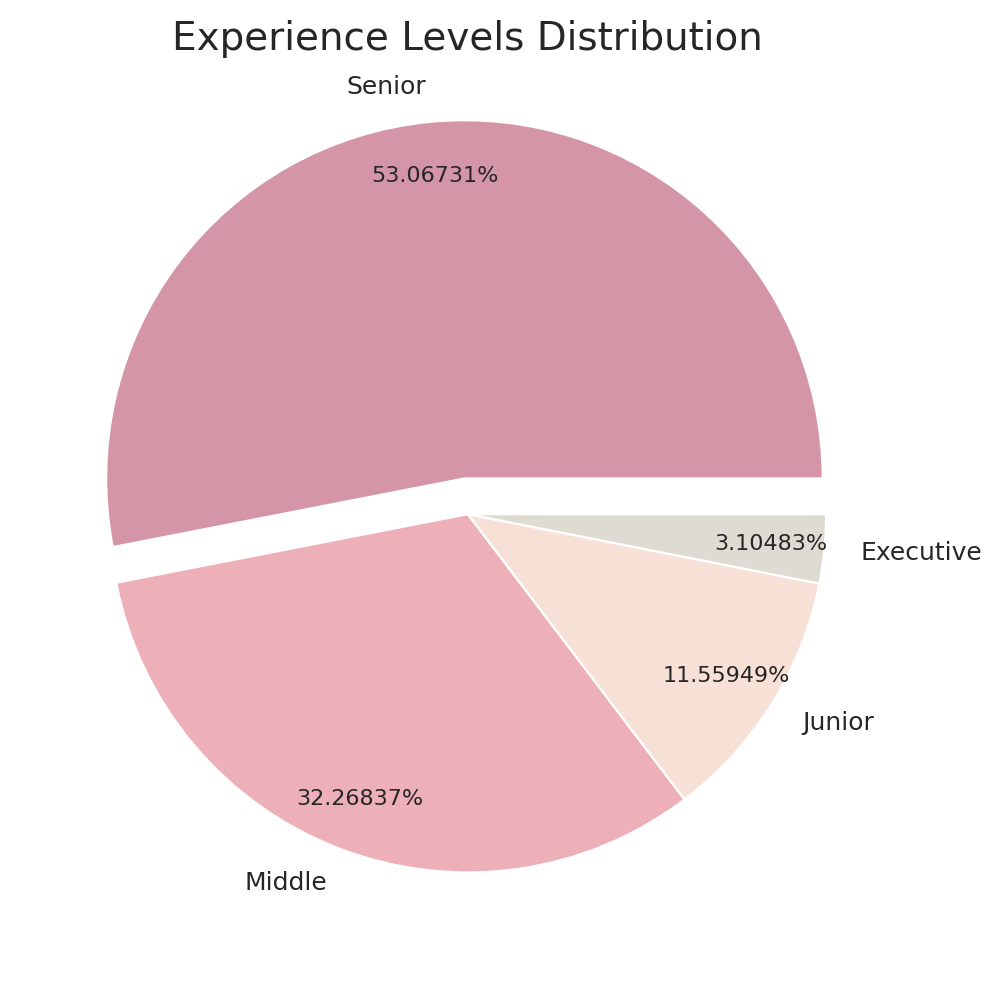

In [33]:
# Get the count of each experience level
experience_counts = salaries['experience_level'].value_counts(normalize=True)

fig, ax = plt.subplots()

explode = [0.1 if i == experience_counts.idxmax() else 0 for i in experience_counts.index]

wedges, texts, autotexts = ax.pie(experience_counts.values,
                                  labels=experience_counts.index,
                                  autopct='%.5f%%',
                                  pctdistance=0.85,
                                  labeldistance=1.1,
                                  explode=explode)

plt.title('Experience Levels Distribution')
plt.setp(autotexts, size=8)

plt.setp(texts, size=9)

plt.tight_layout()
plt.show()

In [34]:
# Employment Type Overall Distribution

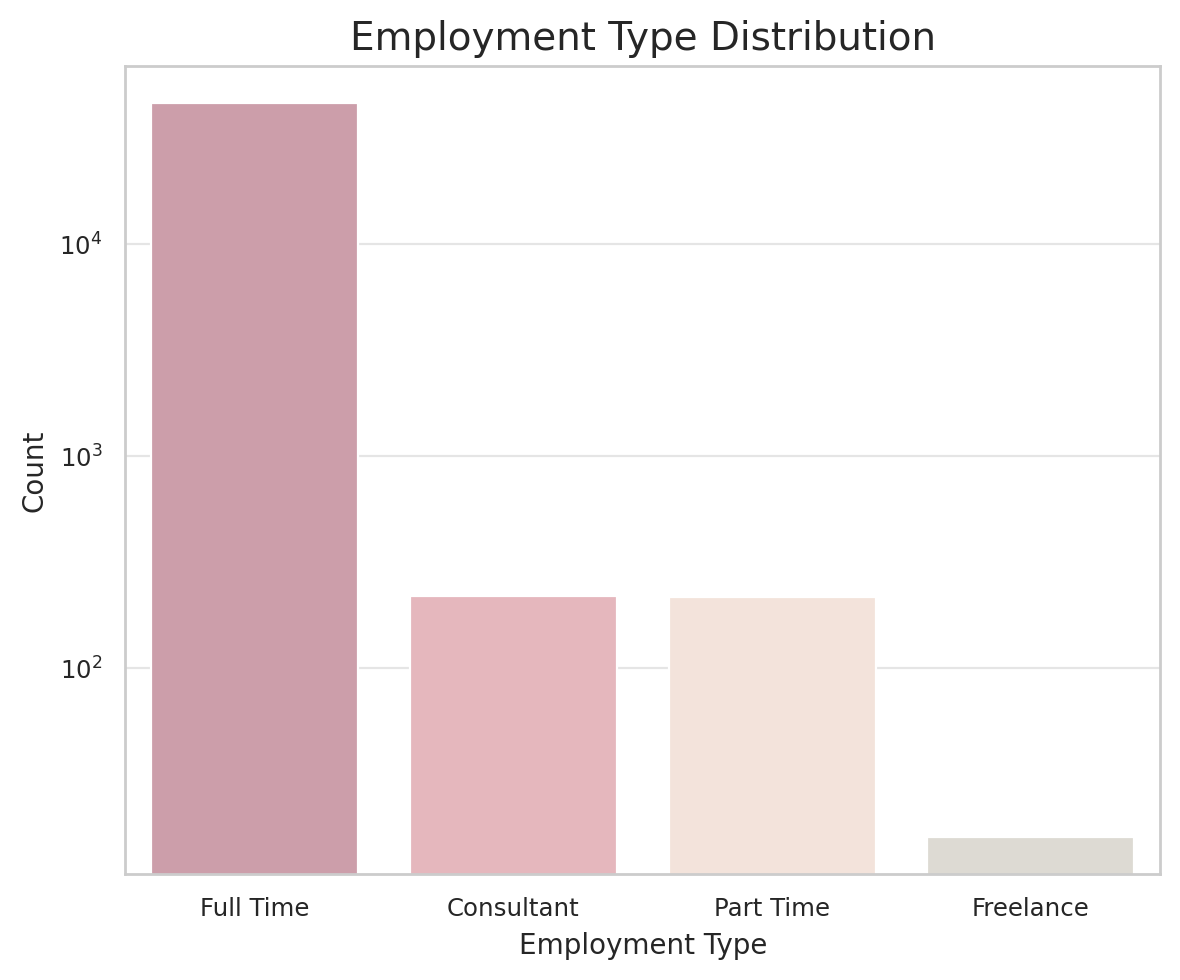

In [35]:
# Calculate normalized counts of employment types
emp_type_counts = salaries['employment_type'].value_counts(normalize=True)

# Create a figure
plt.figure( figsize=(6, 5))
ax = sns.countplot(data=salaries, x='employment_type',
                   order=salaries['employment_type'].value_counts().index,
                   palette=custom_colors)

# Apply log scale to y-axis
ax.set_yscale('log')

# Add titles and labels
plt.title('Employment Type Distribution', fontsize=14)
plt.xlabel('Employment Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.tight_layout()
plt.show()


In [36]:
#  Remote Ratio Overall Distribution

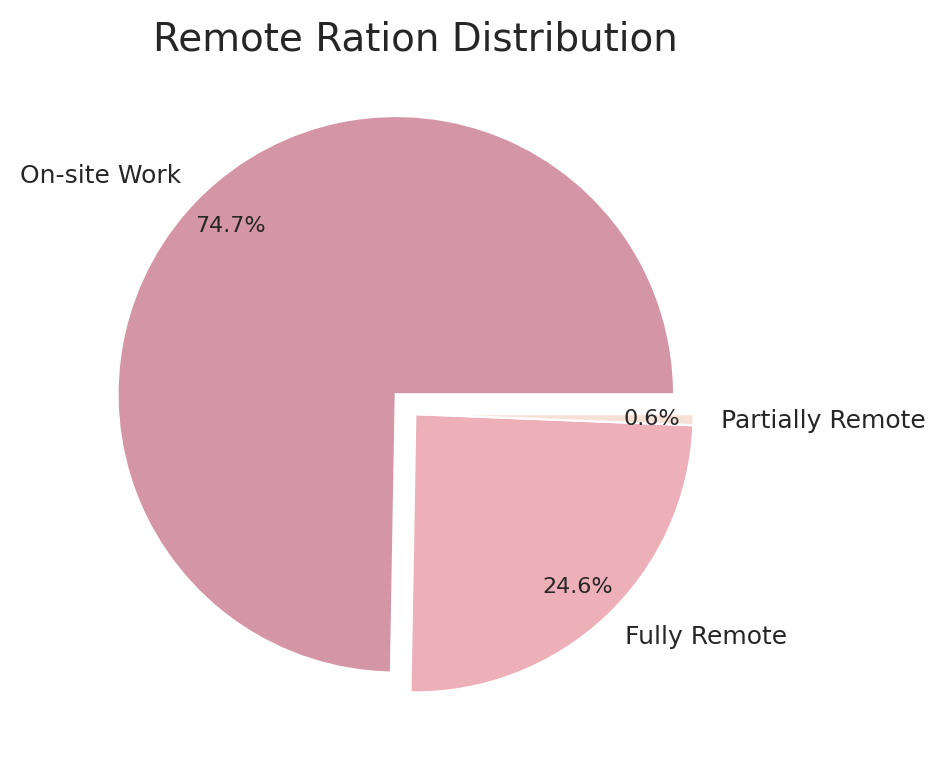

In [37]:
# Get the count of each type of remote_ratio
remote_counts = salaries['remote_ratio'].value_counts(normalize=True)

# Create a figure
fig, ax = plt.subplots( figsize=(5, 4))

# Create an explode list to emphasize the wedge with the highest count (0.1 for the highest count)
explode = [0.1 if i == remote_counts.idxmax() else 0 for i in remote_counts.index]

# Create the pie chart with the specified parameters
wedges, texts, autotexts = ax.pie(remote_counts.values,
                                  labels=remote_counts.index,
                                  autopct='%1.1f%%',
                                  pctdistance=0.85,# Move percentage labels slightly outward from default
                                  labeldistance=1.1,
                                  explode=explode)

plt.title('Remote Ration Distribution')
# Set properties for the percentage labels (autotexts)
plt.setp(autotexts, size=8)

# Set properties for the text labels (texts)
plt.setp(texts, size=9)

plt.tight_layout()
plt.show()

In [38]:
# Company Size Overall Distribution

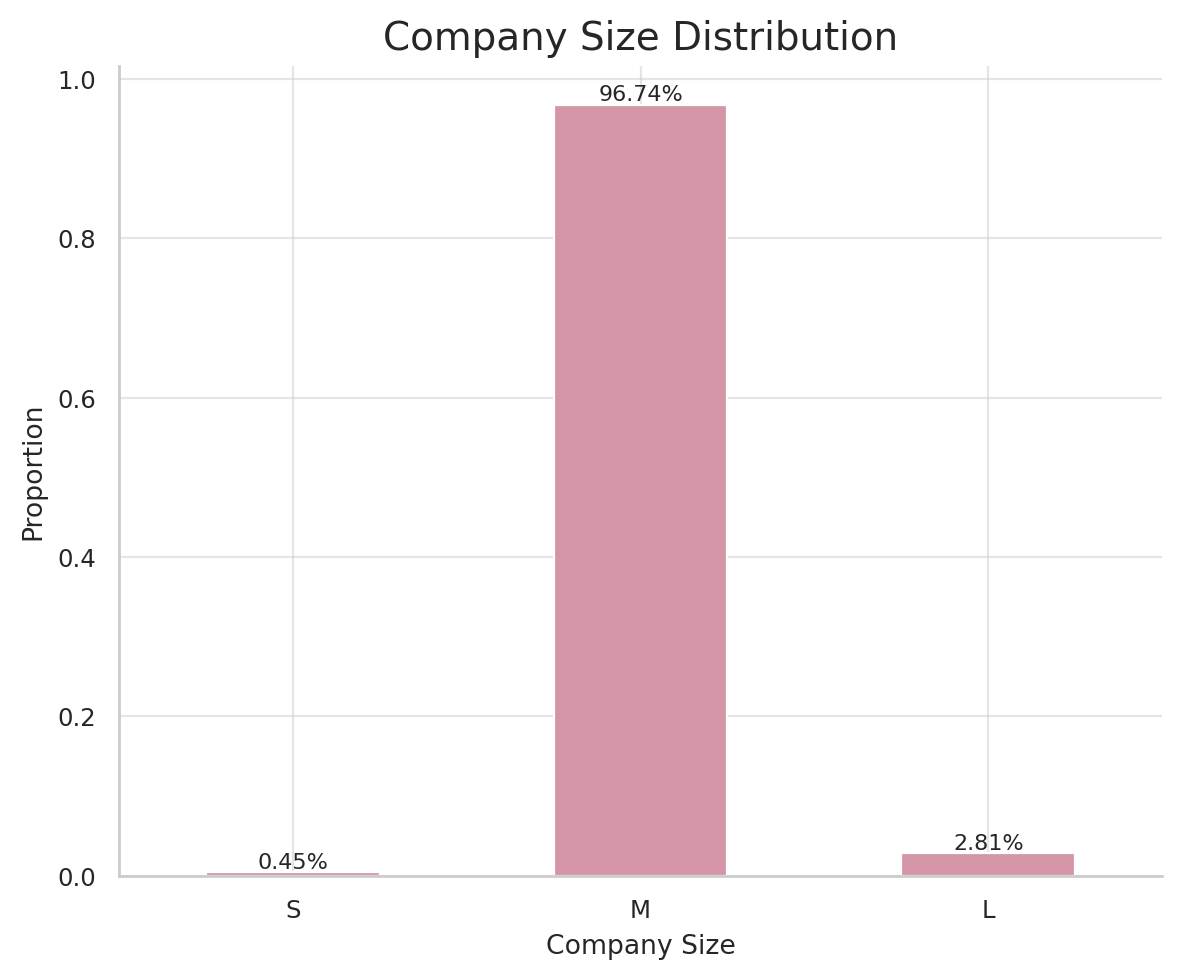

In [39]:
comp_size_data = salaries['company_size'].value_counts(normalize=True).reindex(['S', 'M', 'L'])

# Create the figure
fig, ax = plt.subplots( figsize=(6, 5))

# Create the plot
comp_size_data.plot(kind='bar', color=custom_colors[::8], ax=ax)

# Modify the properties of the plot
ax.set(xlabel='Company Size', ylabel='Proportion', title='Company Size Distribution')

# Rotate x-axis labels
plt.xticks(rotation=0)

# Add percentage labels to the bars
for idx, val in enumerate(comp_size_data.values):
    plt.text(idx, val, f'{val:.2%}', ha='center', va='bottom', fontsize=8)

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

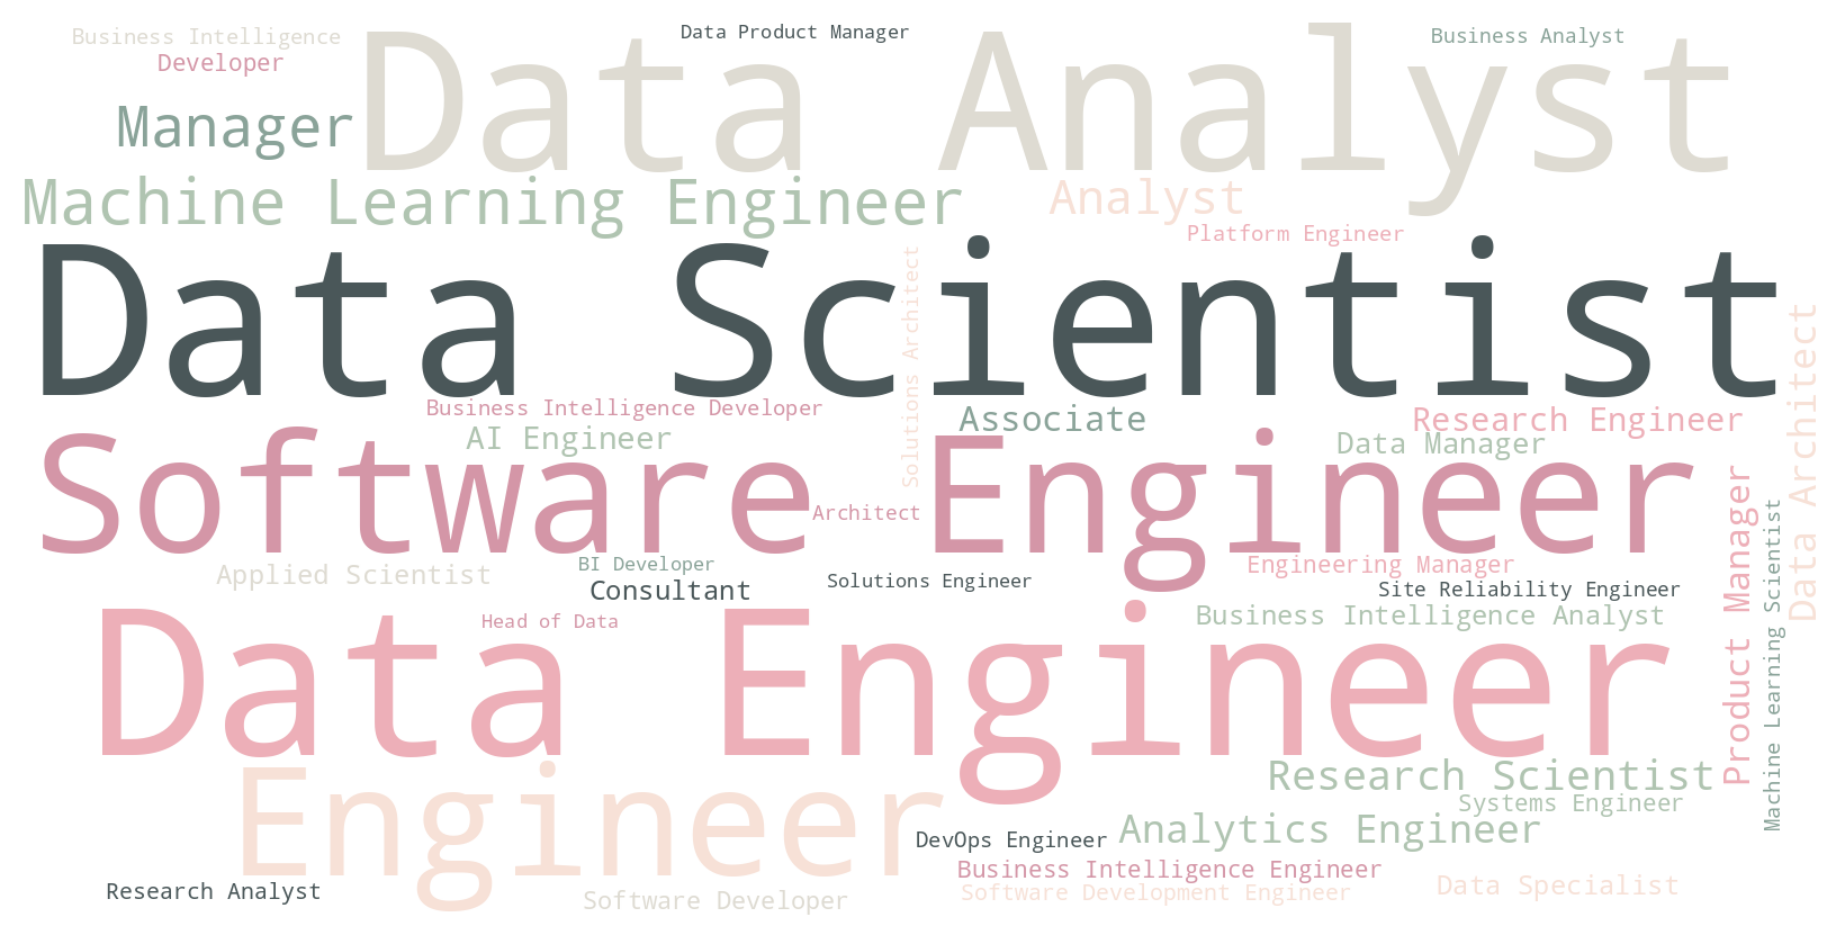

In [40]:
# Word Cloud for Job TItles
job_titles = salaries['job_title'].value_counts().to_dict()

import random
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(custom_colors)

# Generate word cloud with custom colors
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600,
                      height=800,
                      background_color='white',
                      max_words=40,
                      color_func=color_func).generate_from_frequencies(job_titles)

# Display the word cloud
plt.figure(dpi=90)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [41]:
# Top 5 titles

In [42]:
top_5_titles = (salaries['job_title'].value_counts().nlargest(6).index).tolist()

# Join the list elements into a string separated by commas
top_5_titles_str = '\n'.join(top_5_titles)

print(f'Top 5 Job Titles are: \n{top_5_titles_str}')

Top 5 Job Titles are: 
Data Scientist
Data Engineer
Data Analyst
Software Engineer
Engineer
Machine Learning Engineer


In [43]:
salary_stats_by_year = salaries.groupby('work_year')['salary_in_usd'].agg(['mean', 'std']).reset_index()
salary_stats_by_year

,work_year,mean,std
0,2020,102250.866667,82722.309481
1,2021,99309.710280,67254.059738
2,2022,131118.624438,61582.825243
3,2023,150117.904321,70178.011898
4,2024,152311.589431,77145.850454
5,2025,152824.363944,81291.451062


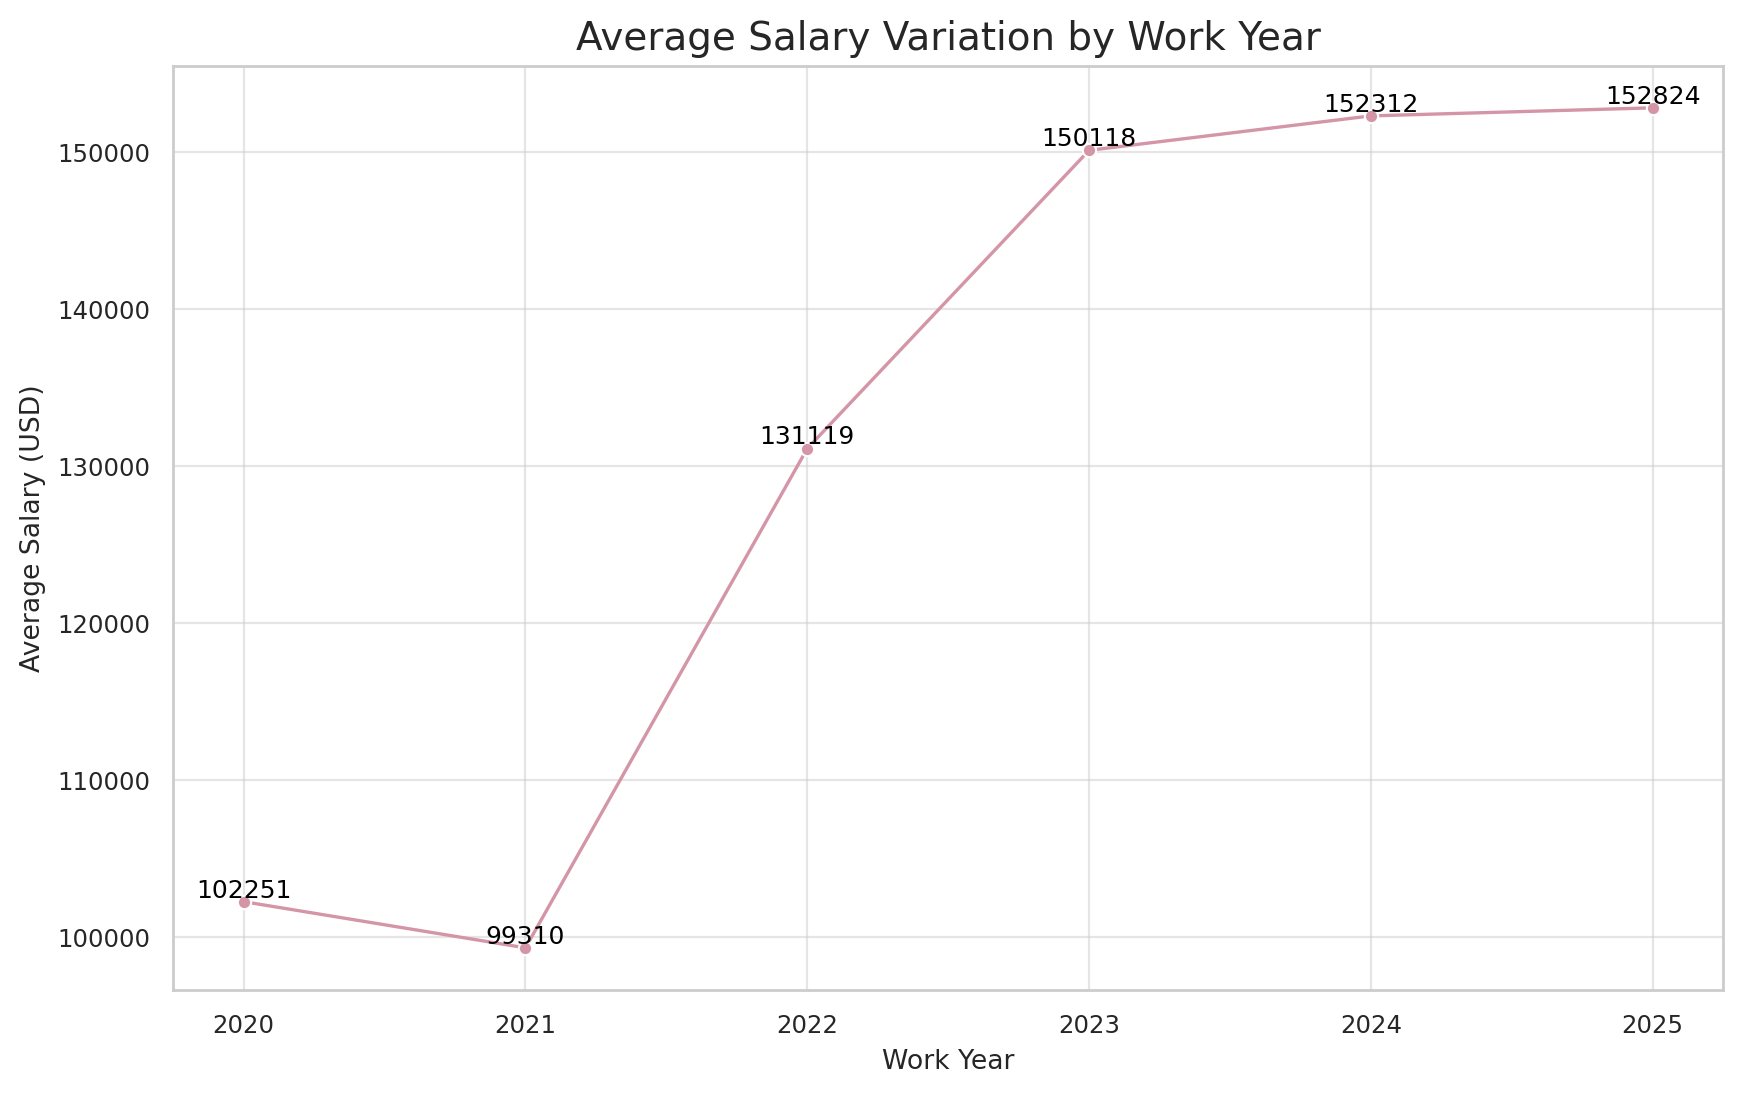

In [44]:
# Group by work_year and calculate average salary for each year
salary_by_year = salaries.groupby('work_year')['salary_in_usd'].mean().reset_index()

# Plot the trend
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=salary_by_year, x='work_year', y='salary_in_usd', marker='o') # Assign the plot to an axis object
plt.title("Average Salary Variation by Work Year")
plt.xlabel("Work Year")
plt.ylabel("Average Salary (USD)")

# Add text labels for each data point using the axis object
for i, row in salary_by_year.iterrows():
    ax.text(row['work_year'], row['salary_in_usd'],
             f"{row['salary_in_usd']:.0f}",
             ha='center', va='bottom', fontsize=9, color='black')

plt.show()

In [45]:
salary_stats = data_science_jobs.groupby('work_year')['salary_in_usd'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
salary_stats.rename(columns={'mean': 'average_salary', 'std': 'salary_std_dev'}, inplace=True)

print(salary_stats)

   work_year  average_salary  salary_std_dev
0       2020   115201.448276    93271.997132
1       2021   103773.671642    67245.552340
2       2022   136145.332237    61902.791481
3       2023   160267.469968    67016.296381
4       2024   155117.134343    74152.035610
5       2025   147966.491556    71884.904570


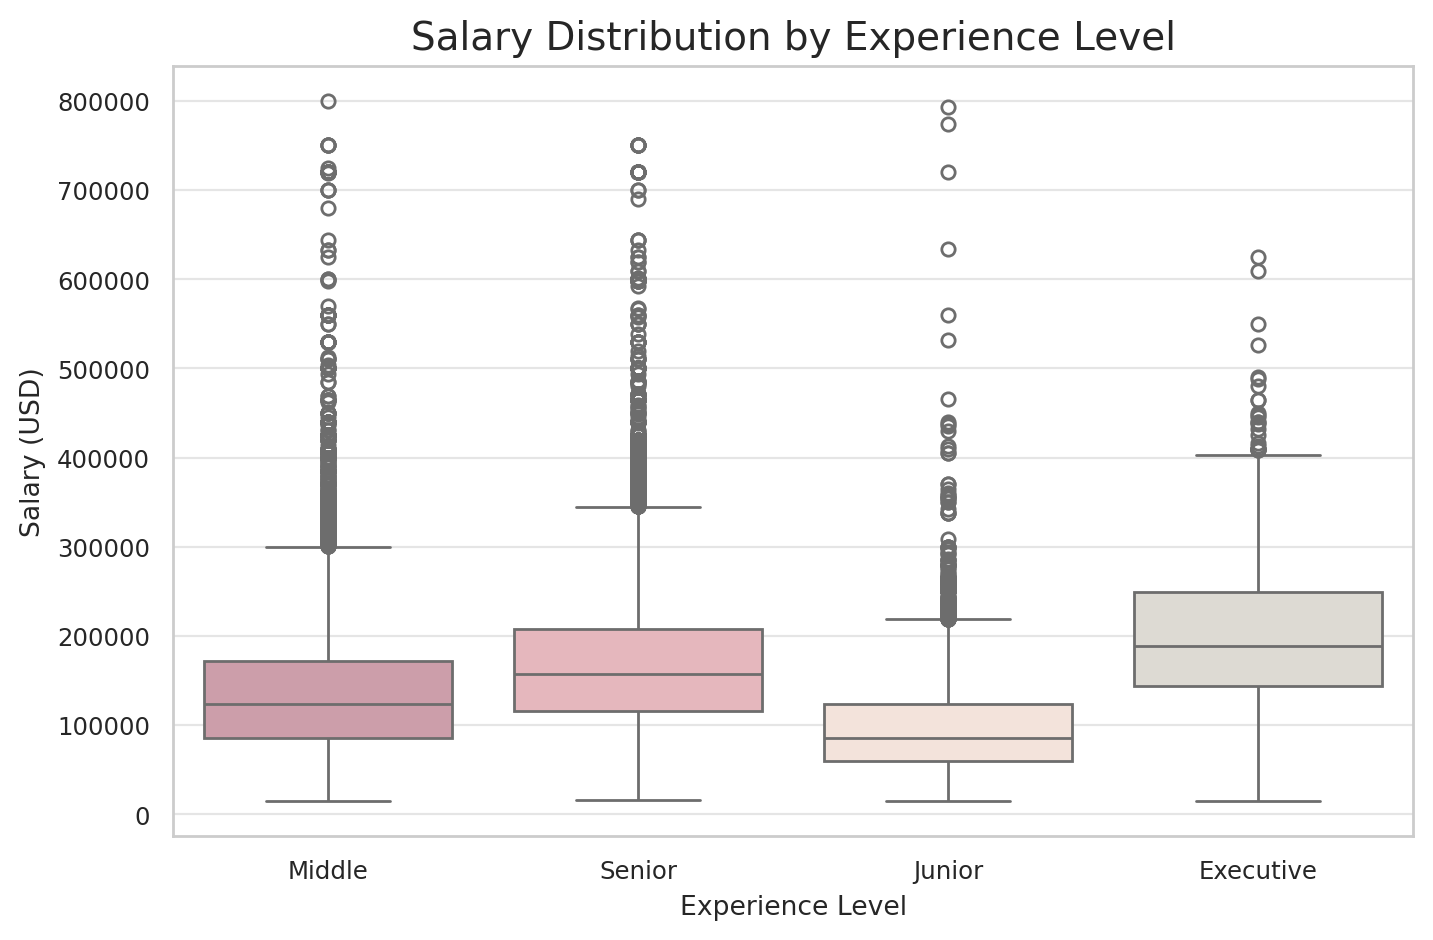

In [46]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=salaries, x='experience_level', y='salary_in_usd', palette=custom_colors)
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')

plt.show()

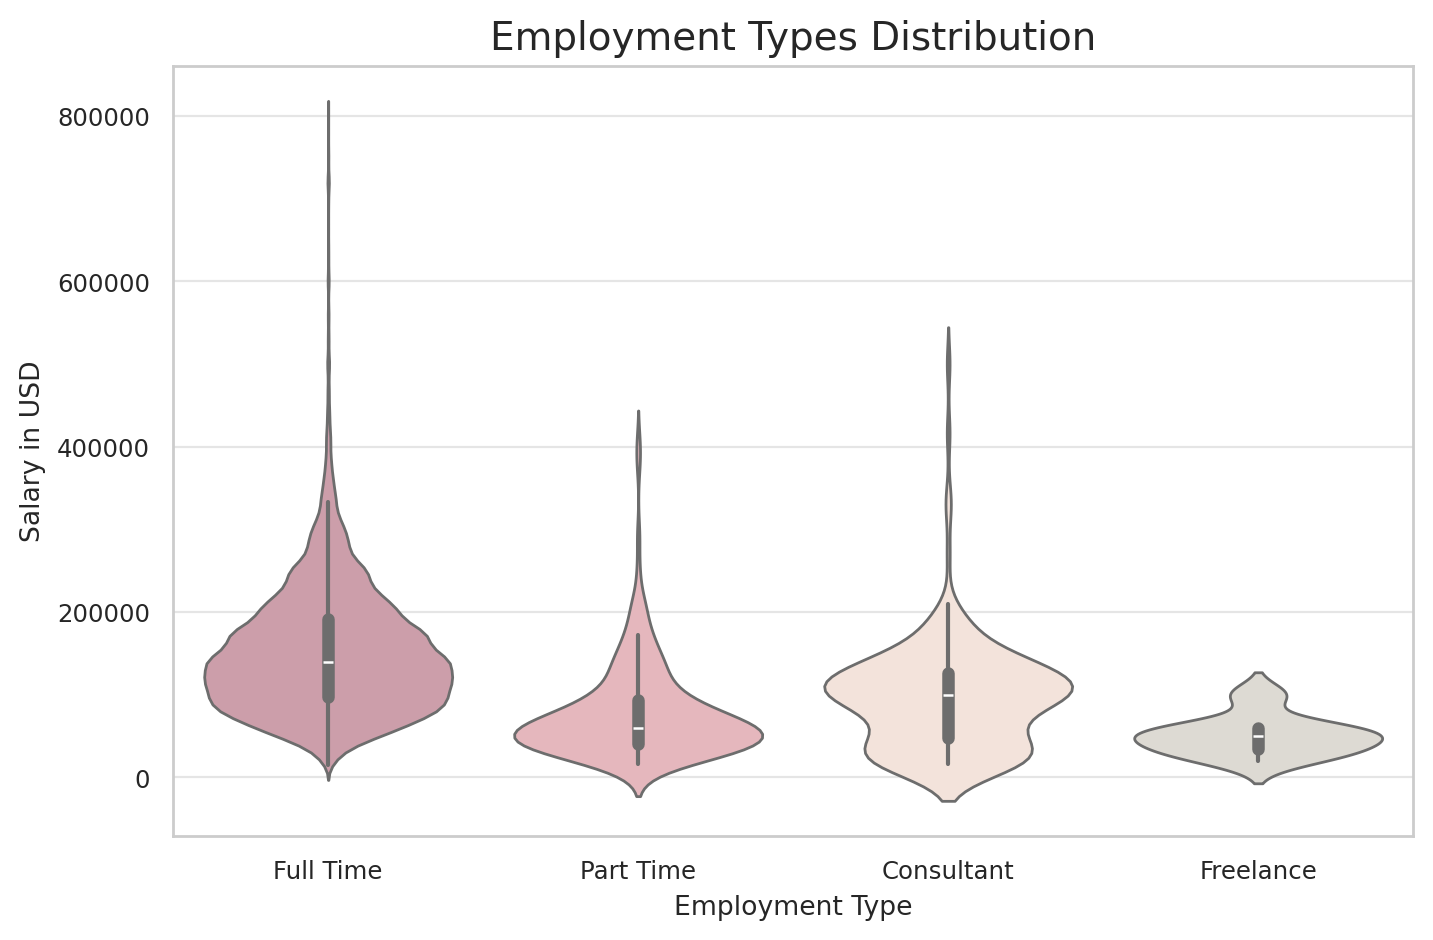

In [47]:
# Salary Distribution by Employment Type
plt.figure(figsize=(8, 5))
sns.violinplot(data=salaries, x='employment_type', y='salary_in_usd', palette=custom_colors, inner='box')
plt.title("Employment Types Distribution")
plt.xlabel("Employment Type")
plt.ylabel("Salary in USD")
plt.show()

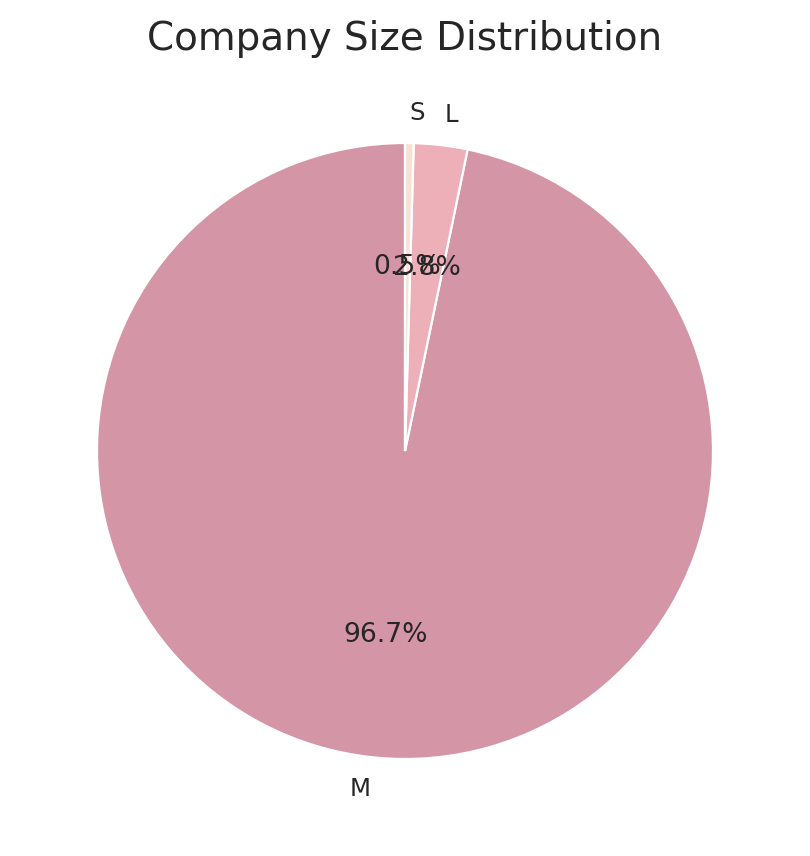

In [48]:
# Pie chart for company size Salary Distribution
company_size_counts = salaries['company_size'].value_counts()
plt.figure(figsize=(6,5))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90, colors=custom_colors)
plt.title("Company Size Distribution")
plt.show()

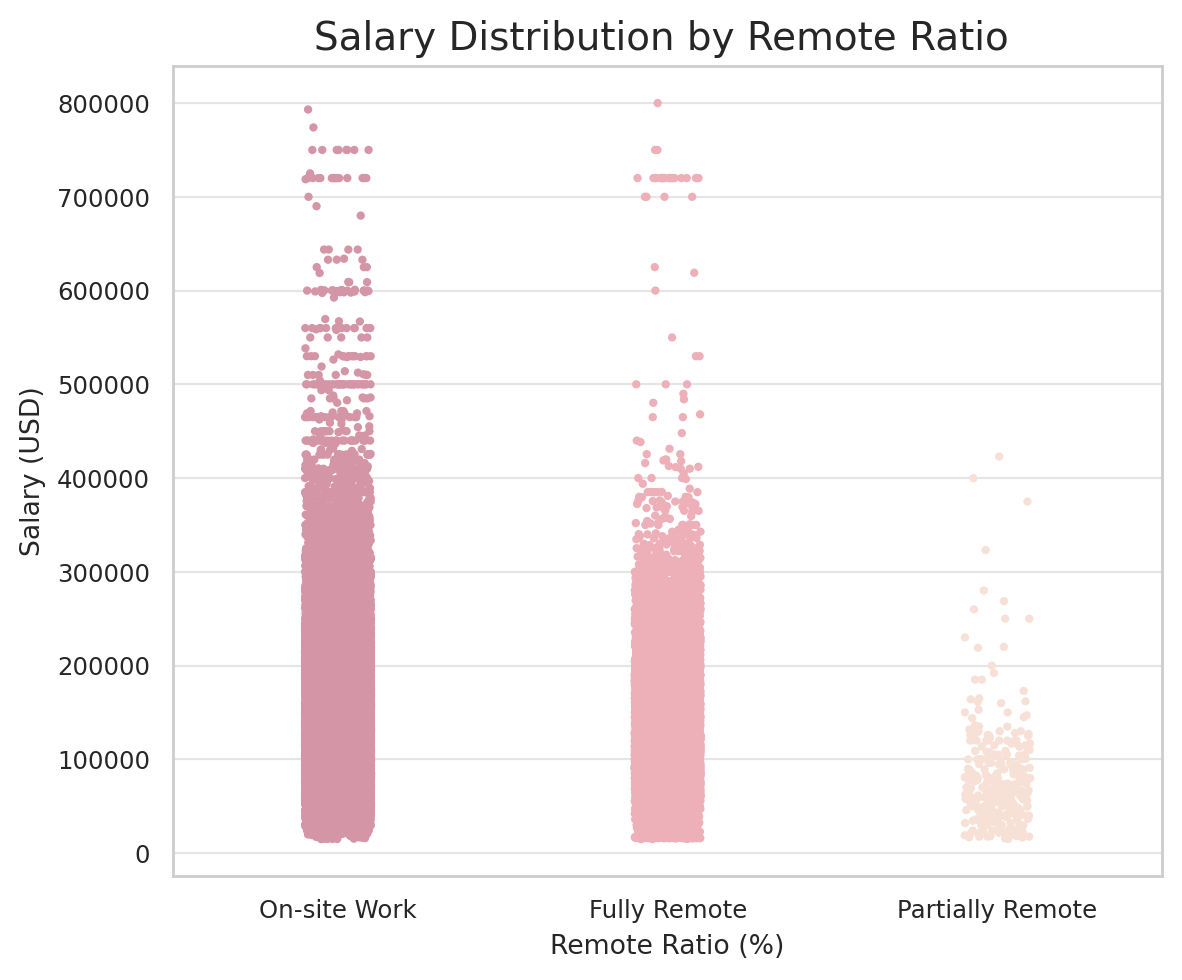

In [49]:
#Salary Distribution by Remote Ratio (Strip Plot)
plt.figure(figsize=(6, 5))
sns.stripplot(data=salaries, x='remote_ratio', y='salary_in_usd', palette=custom_colors, jitter=True, size=3)

plt.title('Salary Distribution by Remote Ratio ')
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Salary (USD)')
plt.tight_layout()
plt.show()


In [50]:
# Statistical Tests
# Hypothesis Testing

In [51]:
# Remote vs. Non-Remote Jobs (T-Test)
# 1.Is there a significant salary difference between remote and non-remote jobs?

In [52]:
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
salaries['remote_ratio']=le.fit_transform(salaries['remote_ratio'])
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,salary_level
0,2025,Middle,Full Time,Research Scientist,208000,USD,208000,US,1,US,M,Research,exec
1,2025,Middle,Full Time,Research Scientist,147000,USD,147000,US,1,US,M,Research,adv
2,2025,Senior,Full Time,Research Scientist,173000,USD,173000,US,1,US,M,Research,adv
3,2025,Senior,Full Time,Research Scientist,117000,USD,117000,US,1,US,M,Research,mid
4,2025,Middle,Full Time,AI Engineer,100000,USD,100000,US,0,US,M,Data Science,mid


In [53]:
# Split the dataset
remote = salaries[salaries['remote_ratio'] == 1]['salary_in_usd']
non_remote = salaries[salaries['remote_ratio'] == 0]['salary_in_usd']

# Perform t-test
t_stat, p_value = ttest_ind(remote, non_remote, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 7.019335021586687
P-value: 2.296154563095847e-12


In [54]:

print("Mean salary (remote):", remote.mean())
print("Mean salary (non-remote):", non_remote.mean())

Mean salary (remote): 153242.98797635446
Mean salary (non-remote): 147668.8850604716


In [55]:
# 2. Do Different Employment Types Affect Salary? (ANOVA)

In [56]:

from scipy.stats import f_oneway

# Group salaries by employment type
ft = salaries[salaries['employment_type'] == 'Full Time']['salary_in_usd']
pt = salaries[salaries['employment_type'] == 'Part Time']['salary_in_usd']
ct = salaries[salaries['employment_type'] == 'Consultant']['salary_in_usd']
fl = salaries[salaries['employment_type'] == 'Freelance']['salary_in_usd']

# Perform one-way ANOVA
f_stat, p_val = f_oneway(ft, pt, ct, fl)

print("F-statistic:", f_stat)
print("P-value:", p_val)

F-statistic: 113.27203490486856
P-value: 4.412570696600266e-73


In [57]:
# Chi-square test : if there's a statistically significant relationship between Company Size and Employment Type

In [58]:
# Create a contingency table: employment type vs. company size
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(salaries['employment_type'], salaries['company_size'])

# Run the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi2 Statistic:", chi2)
print("P-value:", p)


Chi2 Statistic: 1004.7369152723517
P-value: 8.450738844834164e-214


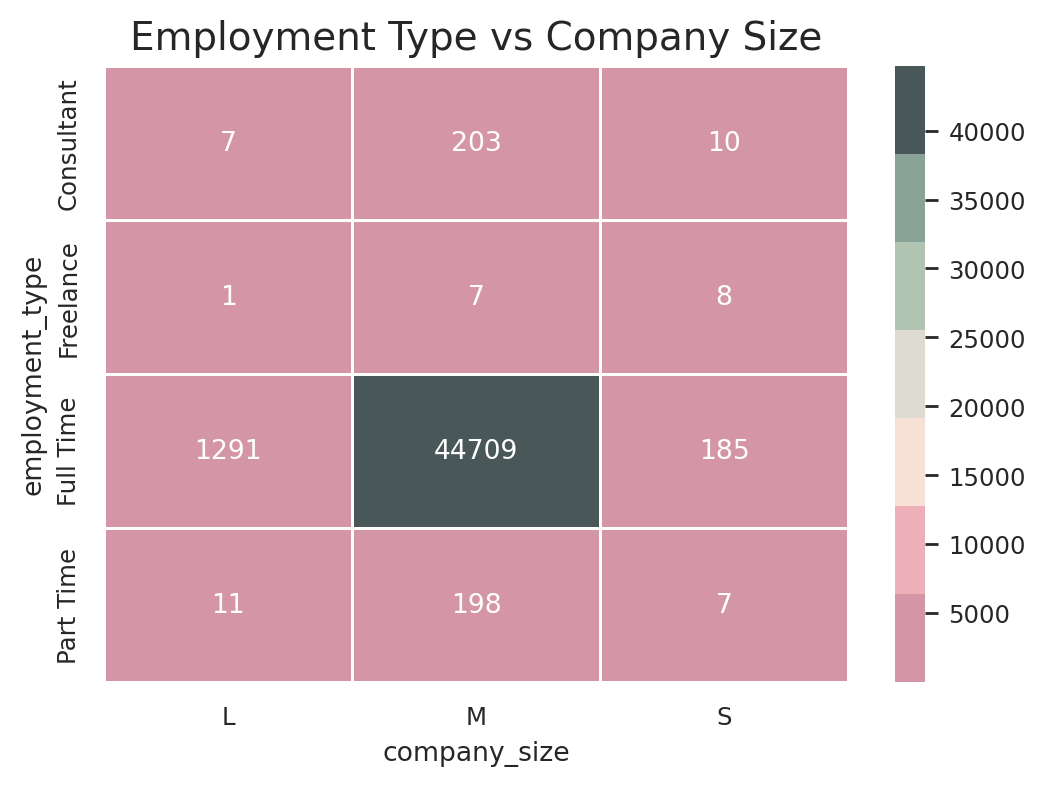

In [59]:
plt.figure(figsize=(6, 4))
sns.heatmap(pd.crosstab(salaries['employment_type'], salaries['company_size']),
            cmap=custom_colors,
            annot=True,  # Display the actual counts
            fmt='d',     # Format the annotations as integers
            linewidths=0.5,
            linecolor='white')
plt.title("Employment Type vs Company Size")
plt.show()

In [60]:
salaries.shape

(46637, 13)

In [61]:
#  Geographic & Industry Focus

In [62]:
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,salary_level
0,2025,Middle,Full Time,Research Scientist,208000,USD,208000,US,1,US,M,Research,exec
1,2025,Middle,Full Time,Research Scientist,147000,USD,147000,US,1,US,M,Research,adv
2,2025,Senior,Full Time,Research Scientist,173000,USD,173000,US,1,US,M,Research,adv
3,2025,Senior,Full Time,Research Scientist,117000,USD,117000,US,1,US,M,Research,mid
4,2025,Middle,Full Time,AI Engineer,100000,USD,100000,US,0,US,M,Data Science,mid


In [63]:
# Create a mapping from country codes to regions
region_map = {
    # North America
    'US': 'North America', 'CA': 'North America', 'MX': 'North America',
    'PR': 'North America', 'BM': 'North America', 'SV': 'North America',
    'HN': 'North America', 'DO': 'North America', 'CR': 'North America',
    'EC': 'South America', 'CL': 'South America', 'AR': 'South America',
    'CO': 'South America', 'PE': 'South America', 'VE': 'South America',
    'BO': 'South America',

    # Europe
    'GB': 'Europe', 'FR': 'Europe', 'DE': 'Europe', 'IT': 'Europe',
    'ES': 'Europe', 'NL': 'Europe', 'SE': 'Europe', 'NO': 'Europe',
    'PL': 'Europe', 'AT': 'Europe', 'CH': 'Europe', 'BE': 'Europe',
    'PT': 'Europe', 'FI': 'Europe', 'IE': 'Europe', 'CZ': 'Europe',
    'SK': 'Europe', 'GR': 'Europe', 'HU': 'Europe', 'BG': 'Europe',
    'HR': 'Europe', 'RO': 'Europe', 'CY': 'Europe', 'LV': 'Europe',
    'LT': 'Europe', 'EE': 'Europe', 'LU': 'Europe', 'SI': 'Europe',
    'MD': 'Europe', 'XK': 'Europe', 'RS': 'Europe', 'UA': 'Europe',
    'BA': 'Europe', 'AD': 'Europe', 'JE': 'Europe', 'MT': 'Europe',

    # Asia
    'IN': 'Asia', 'CN': 'Asia', 'JP': 'Asia', 'KR': 'Asia',
    'SG': 'Asia', 'MY': 'Asia', 'ID': 'Asia', 'TH': 'Asia',
    'VN': 'Asia', 'PH': 'Asia', 'TW': 'Asia', 'HK': 'Asia',
    'UZ': 'Asia', 'KZ': 'Asia', 'AM': 'Asia', 'GE': 'Asia',
    'IL': 'Asia', 'SA': 'Asia', 'AE': 'Asia', 'OM': 'Asia',
    'PK': 'Asia', 'IR': 'Asia', 'QA': 'Asia',

    # Africa
    'ZA': 'Africa', 'NG': 'Africa', 'KE': 'Africa', 'EG': 'Africa',
    'RW': 'Africa', 'UG': 'Africa', 'ZM': 'Africa', 'GH': 'Africa',
    'DZ': 'Africa', 'TN': 'Africa', 'MU': 'Africa', 'CF': 'Africa',

    # Middle East (can also be included under Asia if preferred)
    'TR': 'Middle East', 'LB': 'Middle East', 'IQ': 'Middle East',
     # Oceania
    'AU': 'Australia', 'NZ': 'Australia', 'AS': 'Australia',

    # Unknown/Other (optional handling)
    'KW': 'Middle East'
}
# Map employee_residence to regions using the dictionary
salaries['region'] = salaries['employee_residence'].map(region_map).fillna('Other')


In [64]:
# Compare Average Salaries by Region or Country

top_residences = salaries['region'].value_counts()
print(top_residences)


region
North America    42186
Europe            3498
Australia          313
Asia               293
South America      124
Africa             112
Other               80
Middle East         31
Name: count, dtype: int64


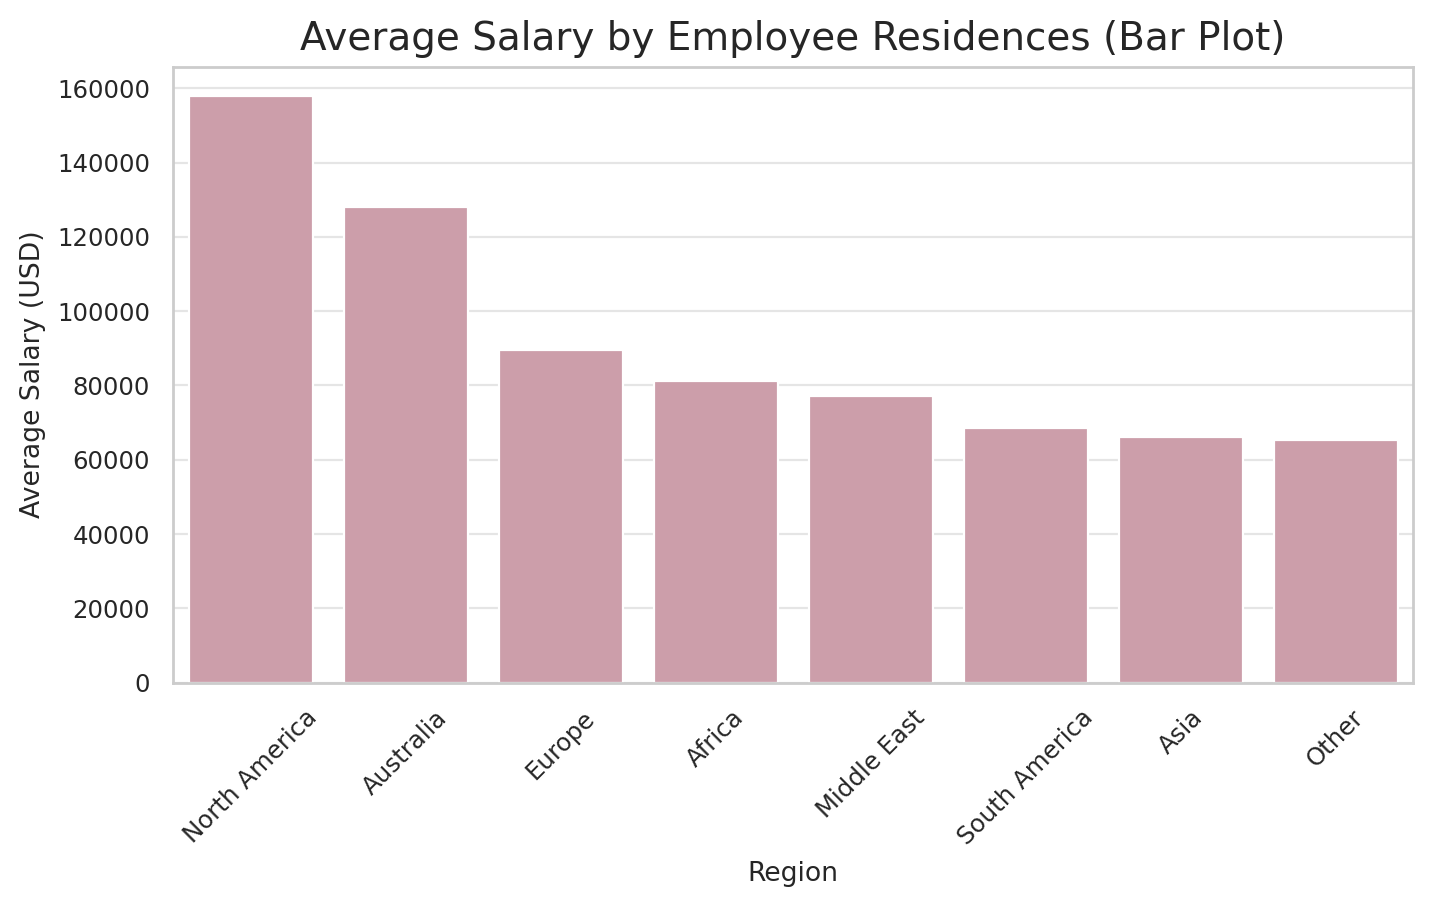

In [65]:
plt.figure(figsize=(8, 4))
mean_salaries = salaries.groupby('region')['salary_in_usd'].mean().sort_values(ascending=False)
sns.barplot(x=mean_salaries.index, y=mean_salaries.values)
plt.xticks(rotation=45)
plt.title("Average Salary by Employee Residences (Bar Plot)")
plt.ylabel("Average Salary (USD)")
plt.xlabel("Region")
plt.show()


In [66]:
# Correlation & Regression Analysis

In [67]:
# salaries=salaries.drop('salary',axis=1)
# salaries.head()

In [68]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
salaries['experience_level']=le.fit_transform(salaries['experience_level'])
salaries['employment_type']=le.fit_transform(salaries['employment_type'])
salaries['job_title']=le.fit_transform(salaries['job_title'])
salaries['employee_residence']=le.fit_transform(salaries['employee_residence'])
salaries['company_location']=le.fit_transform(salaries['company_location'])
salaries['company_size']=le.fit_transform(salaries['company_size'])
salaries['remote_ratio']=le.fit_transform(salaries['remote_ratio'])
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category,salary_level,region
0,2025,2,2,282,208000,USD,208000,89,1,84,1,Research,exec,North America
1,2025,2,2,282,147000,USD,147000,89,1,84,1,Research,adv,North America
2,2025,3,2,282,173000,USD,173000,89,1,84,1,Research,adv,North America
3,2025,3,2,282,117000,USD,117000,89,1,84,1,Research,mid,North America
4,2025,2,2,4,100000,USD,100000,89,0,84,1,Data Science,mid,North America


In [69]:
# X = salaries[['experience_level','employment_type','job_title','company_size','remote_ratio']] # Correct syntax using square brackets to select multiple columns
# y=salaries['salary_in_usd']

In [70]:
X = salaries.select_dtypes(include=[np.number]).drop(columns=['salary_in_usd'])
y = salaries['salary_in_usd']

In [71]:
X.head()

,work_year,experience_level,employment_type,job_title,salary,employee_residence,remote_ratio,company_location,company_size
0,2025,2,2,282,208000,89,1,84,1
1,2025,2,2,282,147000,89,1,84,1
2,2025,3,2,282,173000,89,1,84,1
3,2025,3,2,282,117000,89,1,84,1
4,2025,2,2,4,100000,89,0,84,1


In [72]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)
from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# X_train= sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

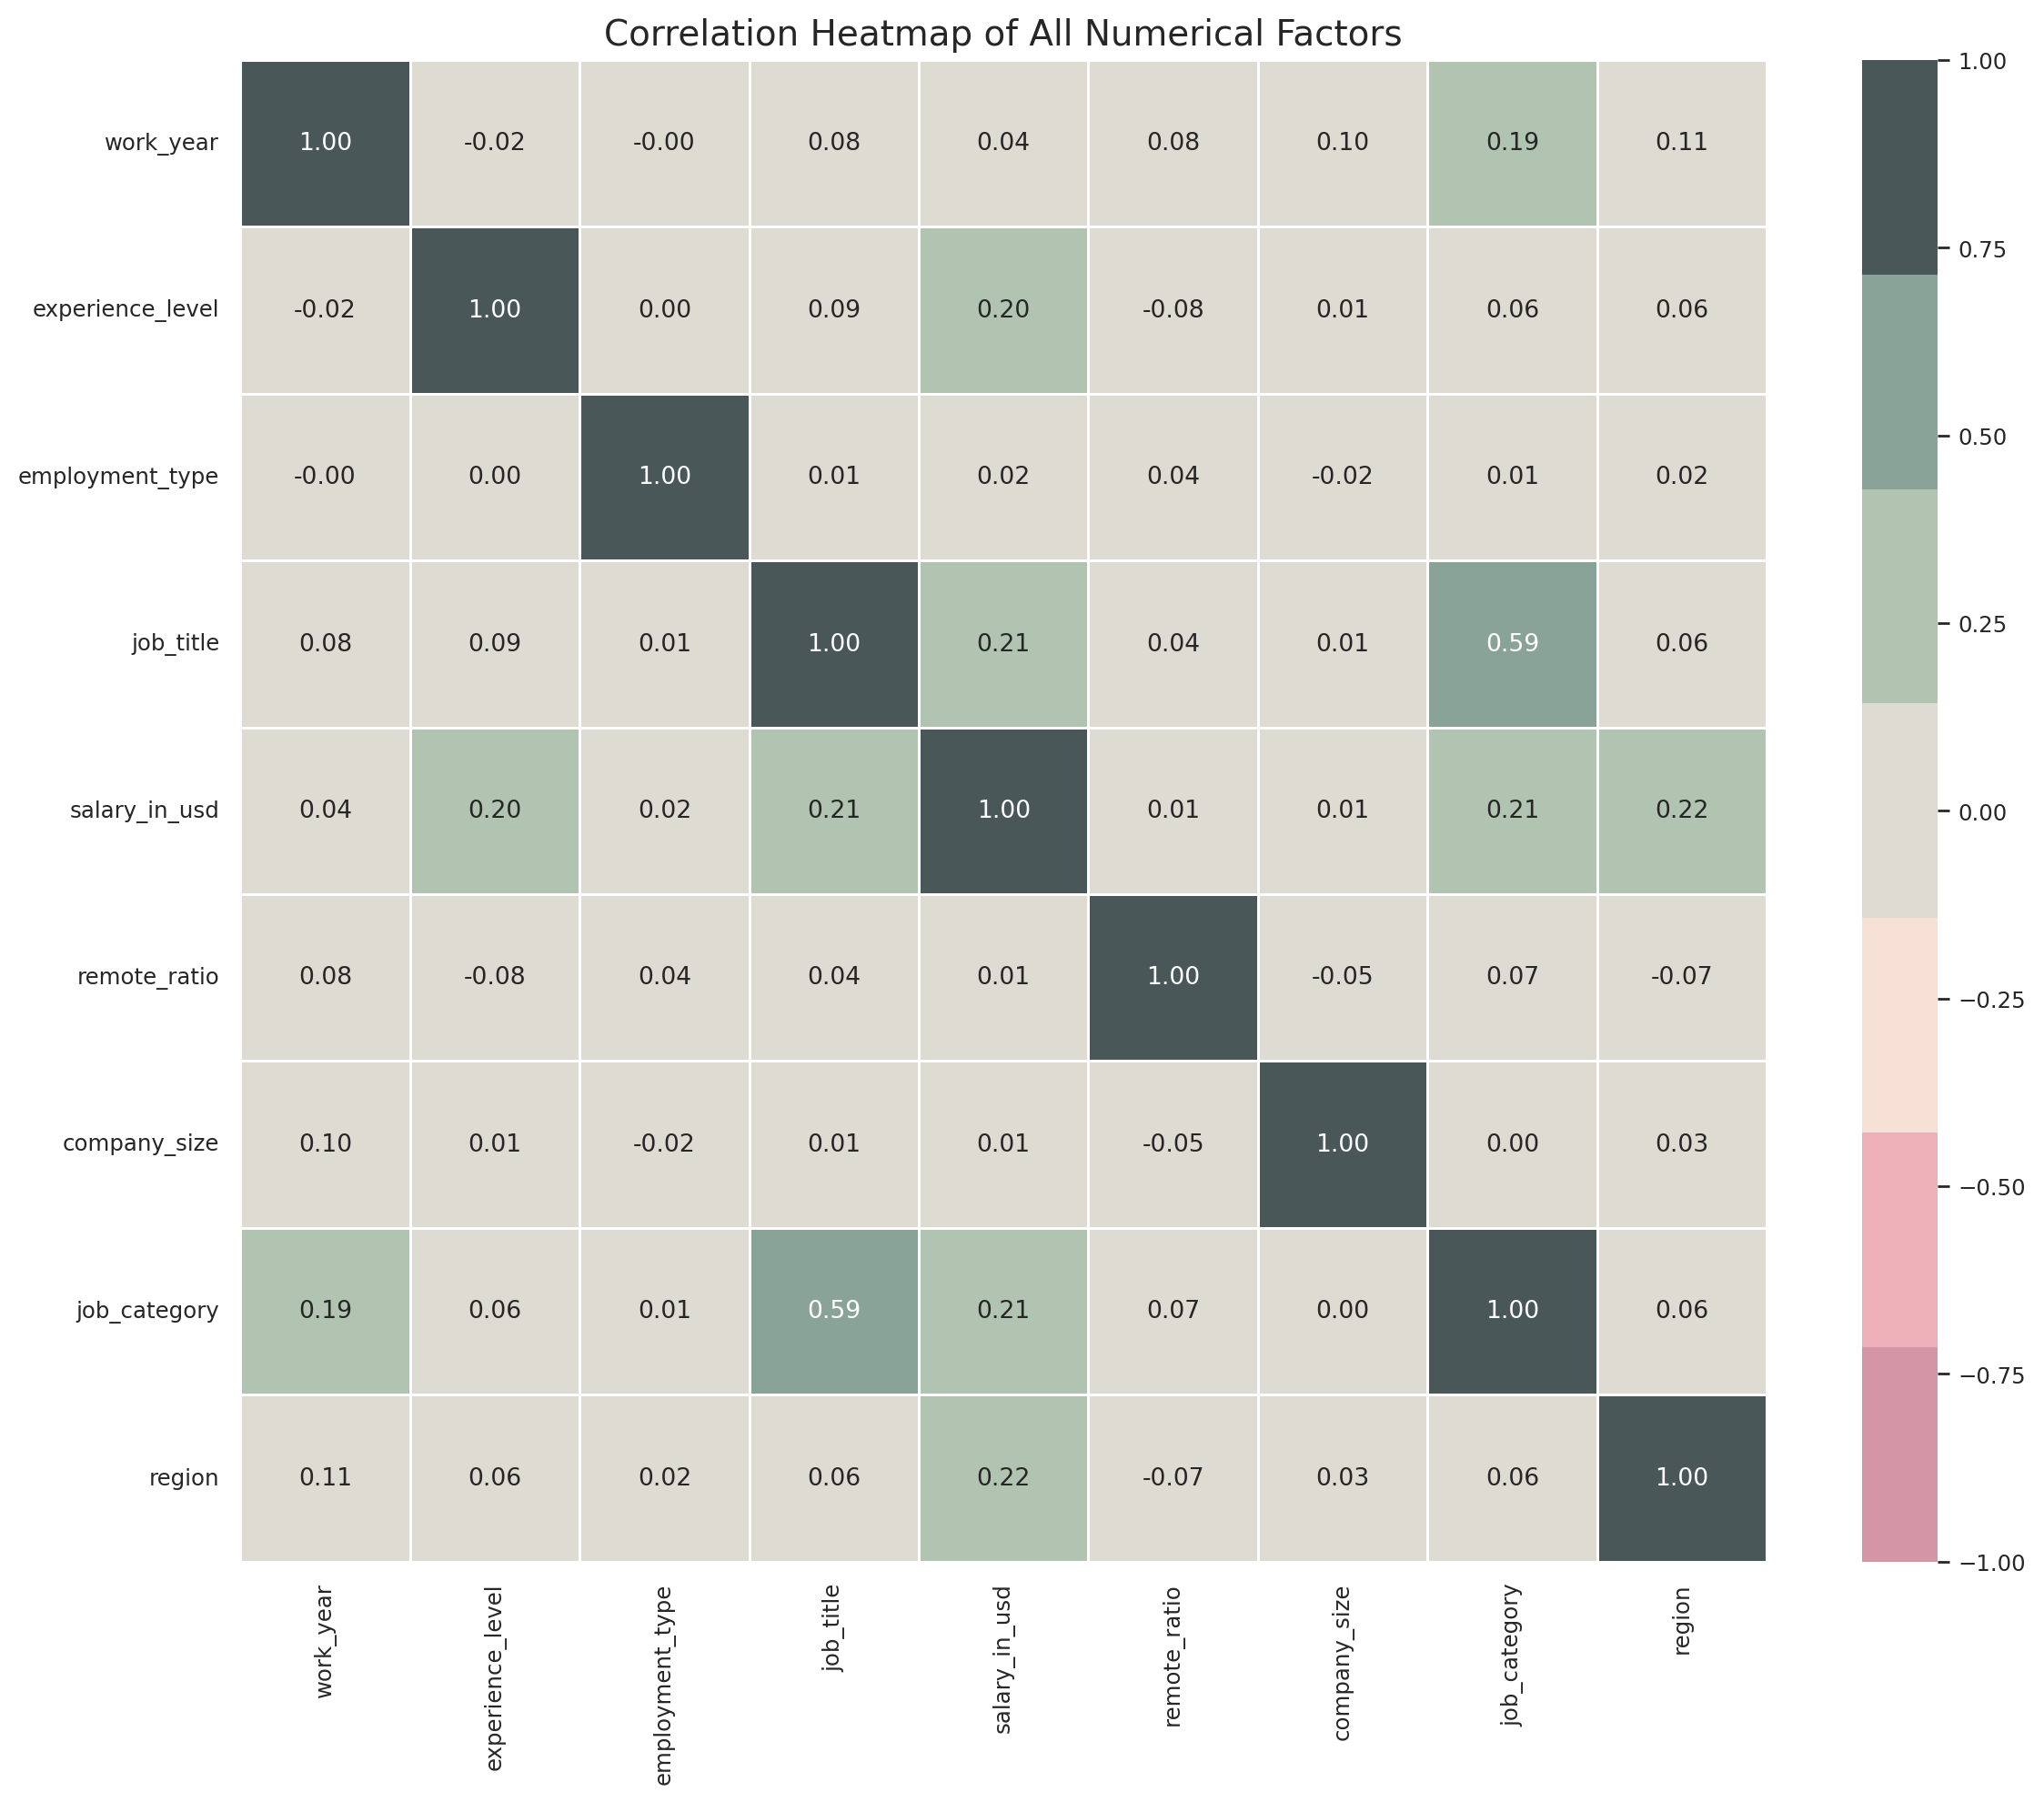

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy of your DataFrame
df = salaries.copy()

# Columns to remove
columns_to_drop = ['salary', 'salary_currency', 'employee_residence', 'company_location']

# Drop the specified columns if they exist in the DataFrame
df = df.drop(columns=columns_to_drop, errors='ignore')


# Convert categorical columns with <30 unique values to numerical codes
for col in df.columns:
    if df[col].dtype == 'object' and df[col].nunique() < 30:
        df[col] = df[col].astype('category').cat.codes

# Compute the correlation matrix for all numerical columns
corr_matrix = df.corr(numeric_only=True)

# Plot the correlation heatmap for the entire matrix
plt.figure(figsize=(12, 10)) # Adjust figure size for better readability
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=custom_colors,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt=".2f" # Format annotations to 2 decimal places
)
plt.title("Correlation Heatmap of All Numerical Factors", fontsize=14)
plt.tight_layout()
plt.show()


GaussianNB Regression:
MAE: 3732.782847341338
RMSE: 480696254.7656947
R²: 0.91730963841752

KNeighbors Regression:
MAE: 1961.9661406518012
RMSE: 228560746.02526927
R²: 0.9606825088712139

DecisionTree Regression:
MAE: 1206.1889794168096
RMSE: 158143246.87780875
R²: 0.9727958723694915

RandomForest Regression:
MAE: 1307.8738595911948
RMSE: 125367581.73416239
R²: 0.9784340099146975

GradientBoosting Regression:
MAE: 2066.5383464638553
RMSE: 100569810.29119052
R²: 0.9826997737244416

XGBRegressor Regression:
MAE: 1700.3917236328125
RMSE: 76411800.0
R²: 0.9868555068969727


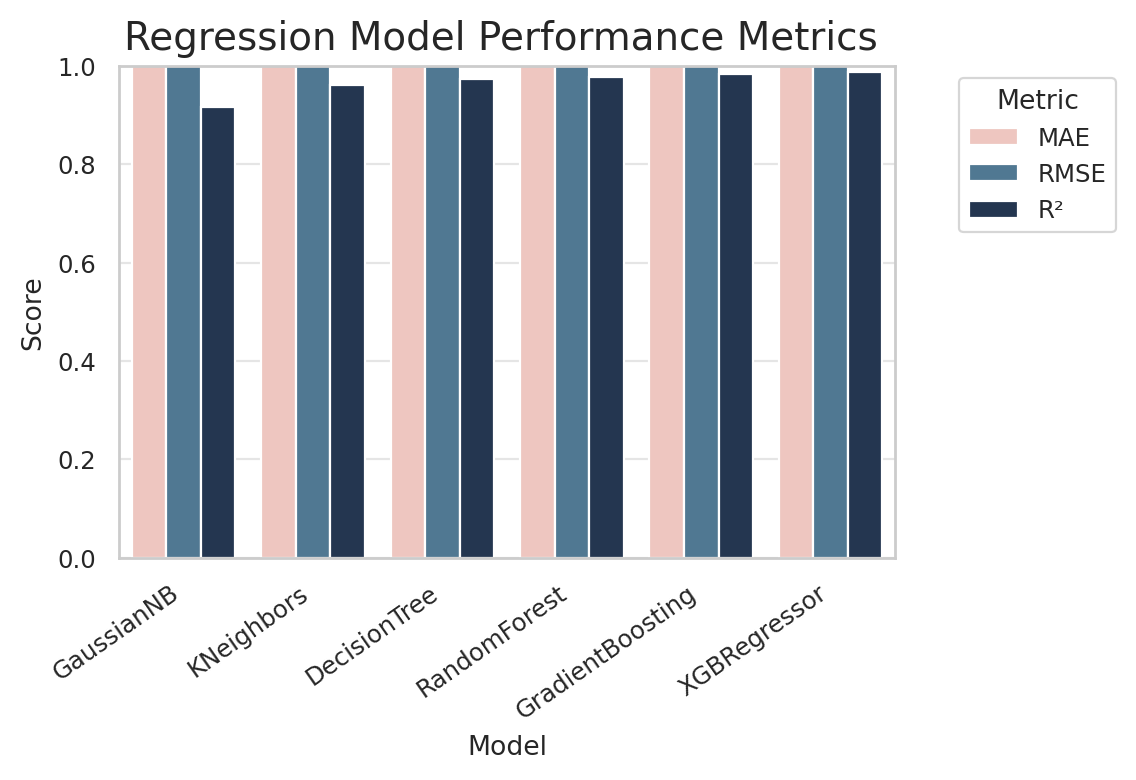

In [74]:
# Train model
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd # Import pandas

# Define models
models = {
    # 'Linear': LinearRegression(),
    # 'Ridge': Ridge(),
    # 'Lasso': Lasso(),
    # # 'Polynomial': PolynomialFeatures(degree=2),
    # 'SVR': SVR(),
    'GaussianNB': GaussianNB(),
    'KNeighbors': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),

}

# Initialize a dictionary to store model metrics
model_metrics = {}

# Run all models in loop
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store metrics in the dictionary
    model_metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

    # Print metrics (optional, as they are now stored)
    print(f"\n{name} Regression:")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R²:", r2)

custom_colors = ['#F6C1B8',  '#457B9D', '#1D3557']
# Convert stored metrics to DataFrame
df_metrics = pd.DataFrame.from_dict(model_metrics, orient='index')
df_metrics = df_metrics.reset_index().rename(columns={'index': 'Model'})

df_metrics_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_metrics_melted,palette=custom_colors)

plt.title('Regression Model Performance Metrics ')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=35, ha='right')
plt.legend(title='Metric', loc='upper right', bbox_to_anchor=(1.3, 1))

# Set the y-axis limits
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [75]:
# TIME SERIES FORECASTING
# Average salary trend over next 5 year

In [76]:
!pip install prophet

In [77]:
# Remove salary outliers
Q1 = salaries['salary_in_usd'].quantile(0.25)
Q3 = salaries['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1
salaries = salaries[(salaries['salary_in_usd'] >= Q1 - 1.5 * IQR) & (salaries['salary_in_usd'] <= Q3 + 1.5 * IQR)]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo7j7cidi/04r3uc_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo7j7cidi/kb0yjyly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94884', 'data', 'file=/tmp/tmpo7j7cidi/04r3uc_b.json', 'init=/tmp/tmpo7j7cidi/kb0yjyly.json', 'output', 'file=/tmp/tmpo7j7cidi/prophet_modeluy9shzpi/prophet_model-20250711042239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

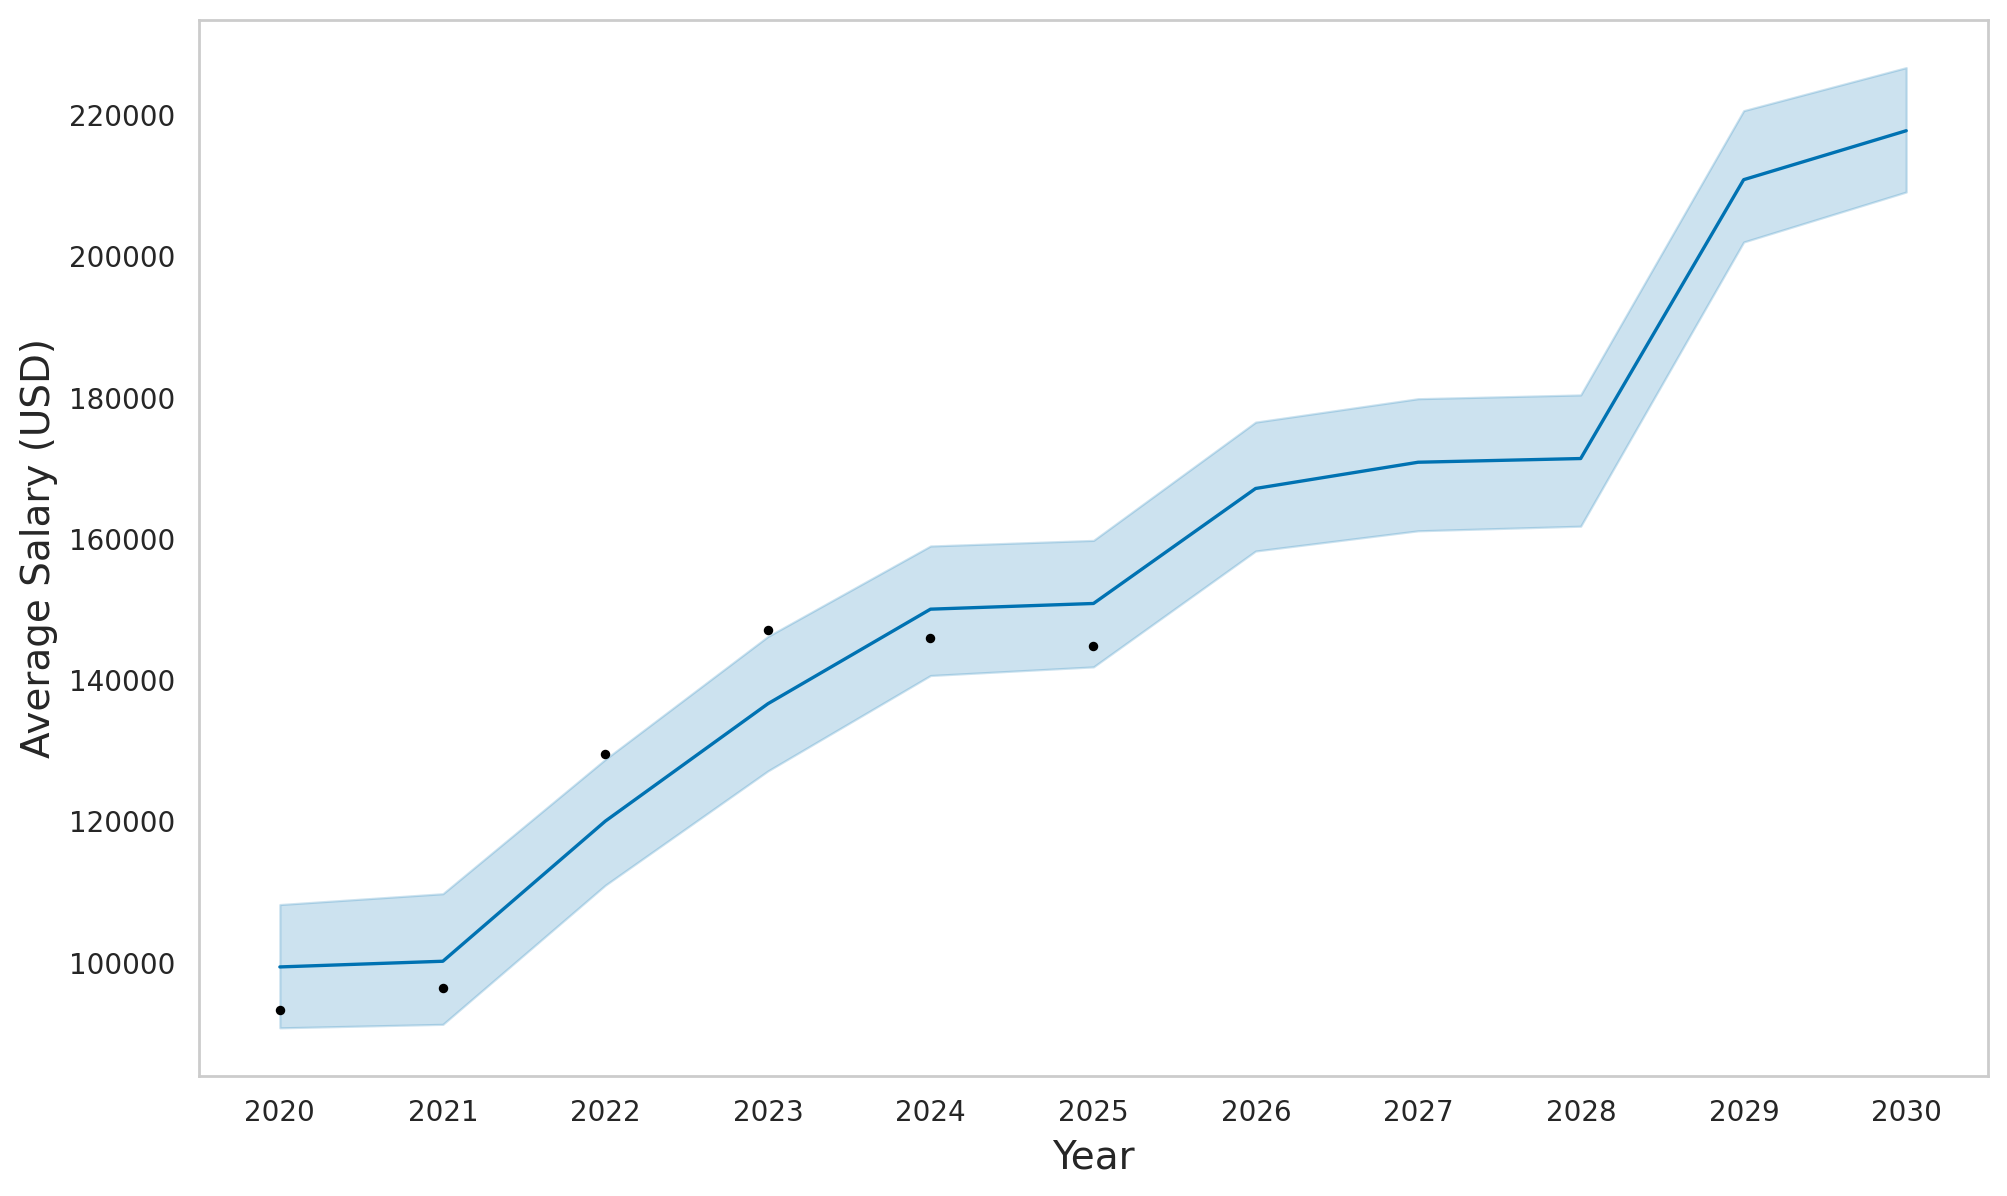

In [78]:
from pickle import FALSE
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Aggregate Salary Data by Year
salary_by_year = salaries.groupby('work_year')['salary_in_usd'].mean().reset_index()
salary_by_year['work_year'] = pd.to_datetime(salary_by_year['work_year'], format='%Y')
salary_by_year.columns = ['ds', 'y']

# Train the Prophet Model
model = Prophet()
model.fit(salary_by_year)

# Forecast for Next 5 Years
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# Visualize Forecast and Remove Grid Lines
fig = model.plot(forecast)
ax = fig.gca()         # Get current axes
ax.grid(False)         # Turn off grid lines

# Increase font size of x and y axis labels and ticks
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Salary (USD)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [79]:
ppp_index = {
    'North America': 1.0,     # baseline
    'Europe': 0.85,
    'Asia': 0.65,
    'South America': 0.55,
    'Australia': 0.95,
    'Africa': 0.50,
    'Middle East': 0.75,
    'Other': 0.70
}

In [80]:
# Map region to its PPP value
salaries['ppp_index'] = salaries['region'].map(ppp_index)

# Create new salary column adjusted for PPP
salaries['salary_ppp_adjusted'] = salaries['salary_in_usd'] / salaries['ppp_index']

In [81]:
# 1..Country-wise Salary Normalization (Cost of Living / PPP Adjustments)

# Salaries in raw USD don't account for differences in cost of living.
# A $100K salary in the U.S. is not equivalent to $100K in India or Switzerland.
#  So, to make fair comparisons, we adjust salaries using Purchasing Power Parity (PPP) or cost of living indices.


In [82]:
# Example: Adjust salaries by PPP index
salaries['salary_ppp_adjusted'] = salaries['salary_in_usd'] / salaries['ppp_index']


In [83]:
country_avg = salaries.groupby('region')['salary_ppp_adjusted'].mean().sort_values(ascending=False)


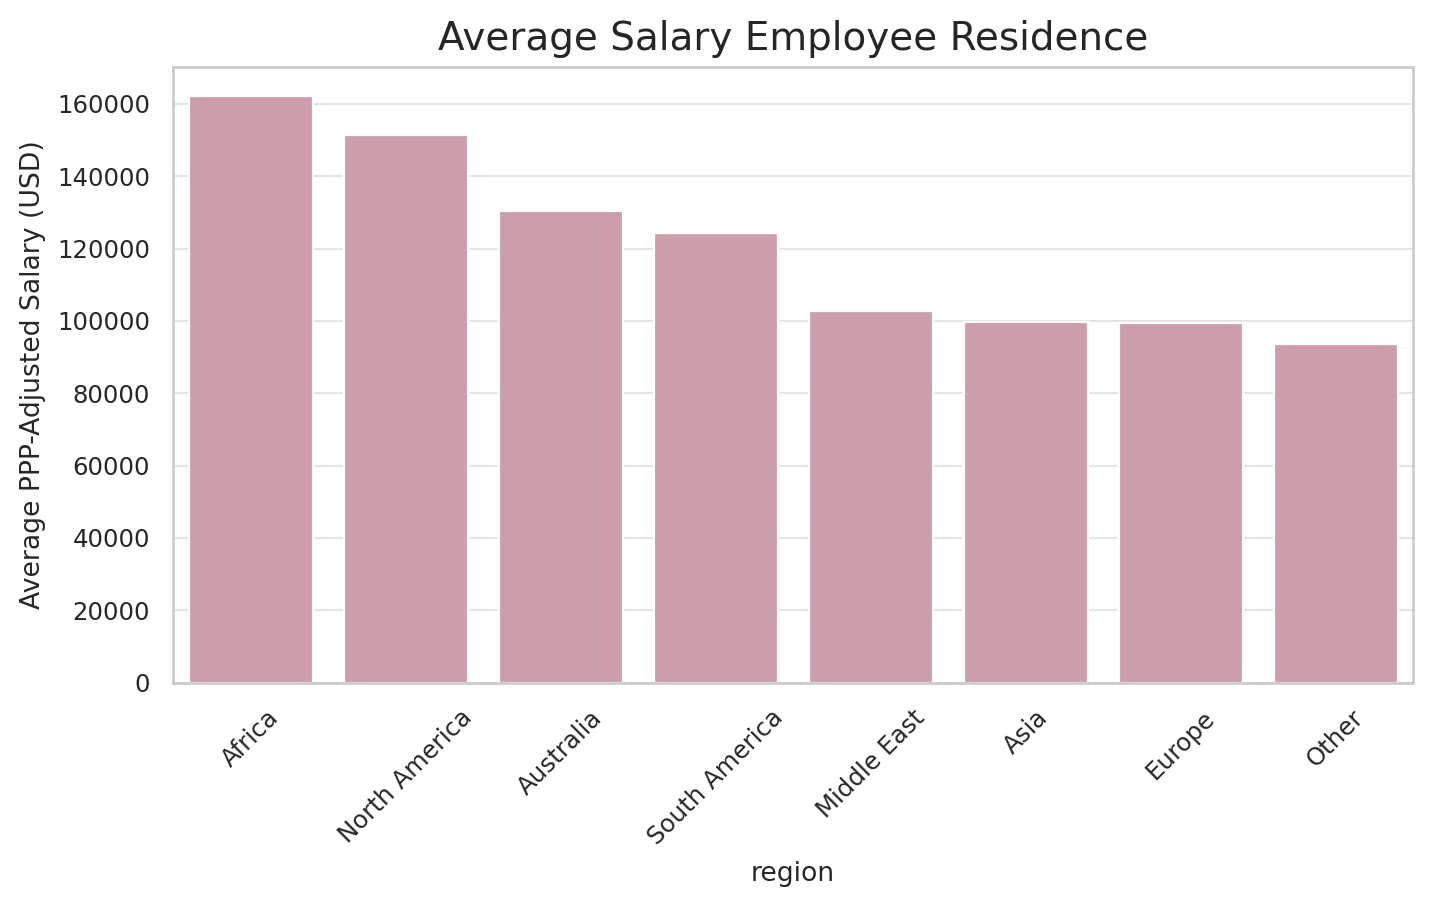

In [84]:
region_avg = salaries.groupby('region')['salary_ppp_adjusted'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=region_avg.index, y=region_avg.values)
plt.xticks(rotation=45)
plt.ylabel("Average PPP-Adjusted Salary (USD)")
plt.title("Average Salary Employee Residence")
plt.show()
